In [1]:
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
import torchtext.data as data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [2]:
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
SEED = 2020
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
plt.rcParams.update({'font.size': 15})

In [4]:
DATA_DIR = {
    "train": "data/train.csv",
    "test": "data/test.csv"
}

In [5]:
datatable = pd.read_csv(DATA_DIR["train"])

In [6]:
display(datatable)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [7]:
datatable = datatable.fillna(value="none")

In [8]:
punctuations = string.punctuation.replace("*","")
stopwords_list = stopwords.words("english")
spacy_tokenizer = torchtext.data.utils.get_tokenizer('spacy')
lemmatizer = WordNetLemmatizer()


def preprocessing(text):
  
    def remove_punctuations(sentence):
        result = "".join([w if w not in punctuations and not w.isdigit() else " " for w in sentence])
        return result
    
    def word_lemmatizer(sentence):
        result = lemmatizer.lemmatize(sentence)
        return result
    
    def word_lowercase(sentence):
        return sentence.lower()
    
    def remove_URL(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        html=re.compile(r'<.*?>')
        text = html.sub(r'',text)
        text = url.sub(r'',str(text))
        return text 
    
    def convert_consecutive(sentence):
        consecutive = re.compile(r'(.)\1\1+')
        sentence = consecutive.sub(r"\1",sentence)
        return sentence
    
    def remove_newline(text):
        return text.rstrip("\n")
    
    def clean(sentence):
        result = []
        sentence = remove_newline(sentence)
        sentence = remove_URL(sentence)
        sentence = convert_consecutive(sentence)
        sentence = word_lowercase(sentence)
        sentence = word_lemmatizer(sentence)
        sentence = remove_punctuations(sentence)
        return sentence
    
 
    text = clean(text)
    if text == "" or text.isspace():
        text = "<unk>"
    return text

In [9]:
def mytokenizer(sentence, train = True):
    sentence = preprocessing(sentence)
    tokens = str.split(sentence)
    if train:
        tokens = [w for w in tokens if w not in stopwords_list]
    return tokens

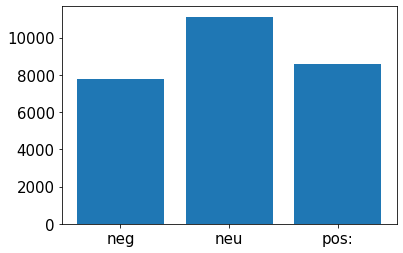

In [10]:
def label_count():
    
    sentiment_count = {
    "neg": len(datatable[datatable["sentiment"] == "negative"]),
    "neu": len(datatable[datatable["sentiment"] == "neutral"]),
    "pos:": len(datatable[datatable["sentiment"] == "positive"])
}

    sentiment = [i for i in sentiment_count.keys()]
    count = [i for i in sentiment_count.values()]
    plt.bar(sentiment, count)
    plt.show()
    
label_count()

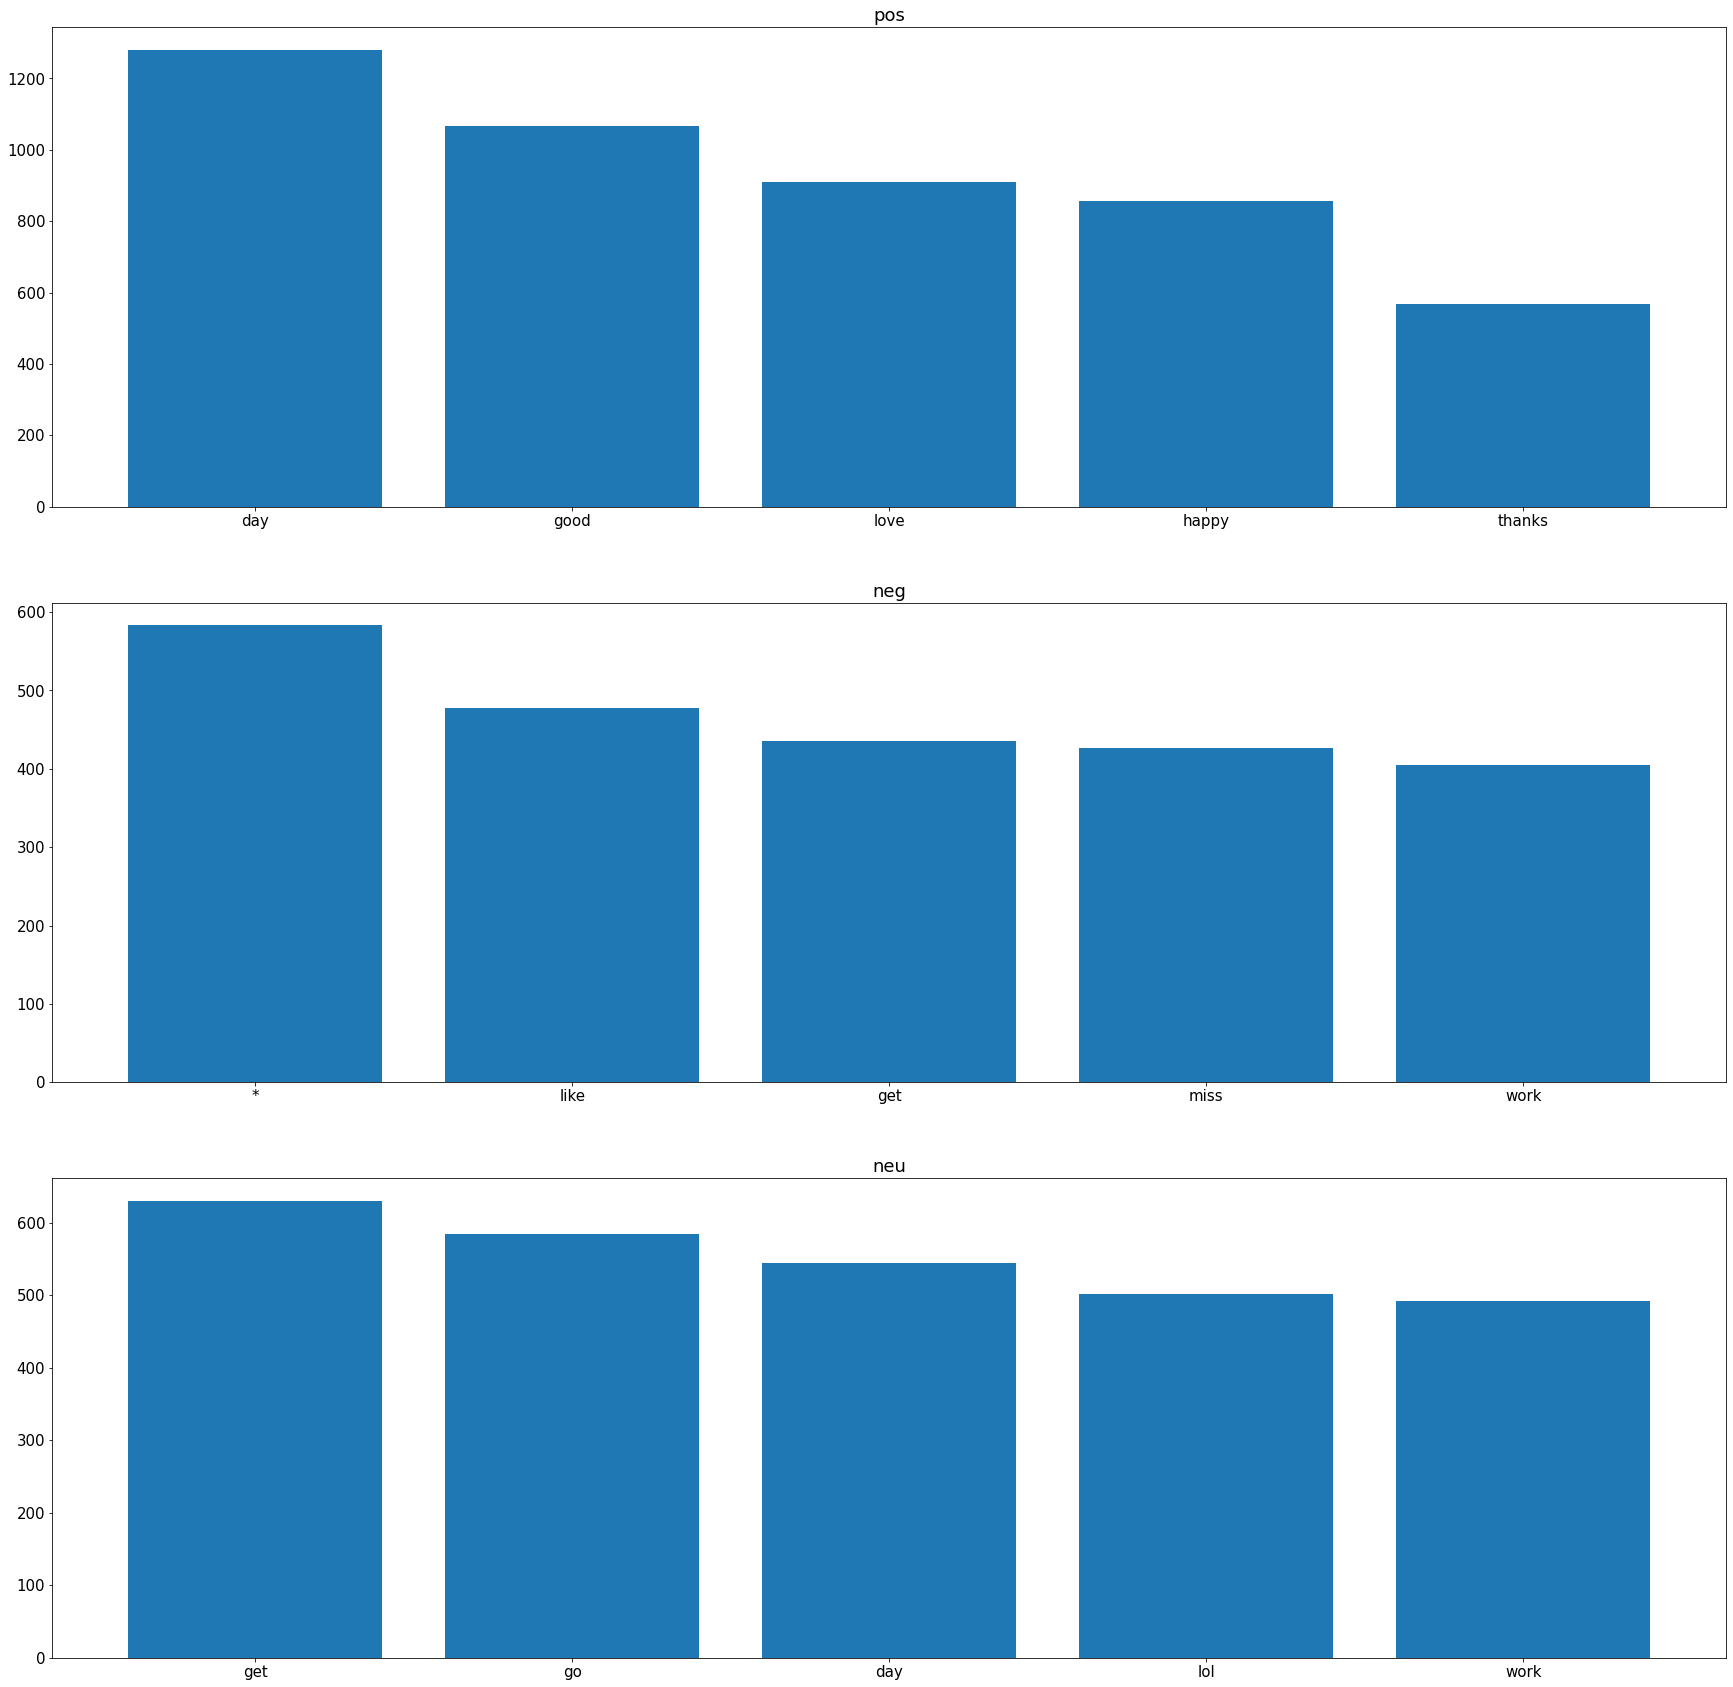

In [11]:
def visualize_top_k(k = 10):
    
    positive_rows = datatable[datatable["sentiment"] == "positive"]["text"]
    negative_rows = datatable[datatable["sentiment"] == "negative"]["text"]
    neutral_rows = datatable[datatable["sentiment"] == "neutral"]["text"]
    
    def build_vocab(rows):
        def sort_dict(d):
            result = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}
            return result
        vocab_dict = {}
        for i in rows:
            k = mytokenizer(i)
            for j in k:
                vocab_dict[j] = 1 if j not in vocab_dict else vocab_dict[j]+1
        vocab_dict = sort_dict(vocab_dict)
        return vocab_dict
    
    vocab_dict = {
        "pos" : build_vocab(positive_rows),
        "neg": build_vocab(negative_rows),
        "neu": build_vocab(neutral_rows)
    }
    
    
    def get_top_k(vocab_dict, k=10):
        top_k_x = [i for i in vocab_dict.keys()]
        top_k_y = [i for i in vocab_dict.values()]
        return top_k_x[:k],top_k_y[:k]
    
    top_k = {
        "pos": get_top_k(vocab_dict["pos"],k),
        "neg": get_top_k(vocab_dict["neg"],k),
        "neu": get_top_k(vocab_dict["neu"],k)
    }
    
    fig = plt.figure(figsize=(30,30))
    for idx,i in enumerate(["pos", "neg", "neu"]):
        fig.add_subplot(3,1,idx+1)
        plt.title(i)
        plt.bar(*top_k[i])
    plt.show()
    
    
visualize_top_k(5)

In [12]:
st = "egh blah and boooooooooooo i dunno wanna go to work  HANGOVERS SUCKKKKKK Im a drunk mess!"
print(st)
print(preprocessing(st))

egh blah and boooooooooooo i dunno wanna go to work  HANGOVERS SUCKKKKKK Im a drunk mess!
egh blah and bo i dunno wanna go to work  hangovers suck im a drunk mess 


In [13]:
TEXT = data.Field(batch_first=True,
                 tokenize=mytokenizer)
TEXT2 = data.Field(batch_first=True,
                 tokenize=mytokenizer)
LABEL = data.LabelField(dtype=torch.float)
IDS = data.LabelField()

In [14]:
FIELDS = [["ID", None],["text",TEXT],["selected",TEXT2], ["label",LABEL]]
TEST_FIELDS = [["id", IDS],["text",TEXT] , ["label",LABEL]]

trainset = data.TabularDataset(DATA_DIR["train"],
                             format = "csv",
                             fields = FIELDS,
                            skip_header = True)

valset = data.TabularDataset(DATA_DIR["test"],
                             format = "csv",
                             fields = TEST_FIELDS,
                            skip_header = True)

new_set = trainset+valset
list_set = [x for x in new_set]
newset = torchtext.data.Dataset(list_set,[('text',TEXT),('label',LABEL)])

print(f"Number of training samples: {len(trainset)}")
print(f"Number of validating samples: {len(valset)}")
print(f"Number of join samples: {len(newset)}")

Number of training samples: 27481
Number of validating samples: 3534
Number of join samples: 31015


In [15]:
TEXT.build_vocab(newset,
                vectors = "glove.6B.100d",
                unk_init = torch.Tensor.normal_)
LABEL.build_vocab(trainset)
TEXT2.build_vocab(trainset)
IDS.build_vocab(valset)

print(f"Unique words in training set: {len(TEXT.vocab)}")
print(f"Unique labels in training set: {len(LABEL.vocab)}")

Unique words in training set: 24429
Unique labels in training set: 3


In [16]:
BATCH_SIZE = 128

train_iter = data.BucketIterator(trainset,
                                batch_size=BATCH_SIZE,
                                device = device)

val_iter = data.BucketIterator(valset,
                                batch_size=BATCH_SIZE,
                                device = device)

new_iter = data.BucketIterator(newset,
                                batch_size=BATCH_SIZE,
                                device = device)

In [17]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
    
        super().__init__()     
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        embedded = self.embedding(text)   
        
        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs] 
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [18]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 3
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4,weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
print(model)

CNN(
  (embedding): Embedding(24429, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,564,103 trainable parameters


In [20]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [21]:
def calc_accuracy(outputs, labels):
    predictions = torch.max(outputs, 1)[1]
    correct = (predictions == labels)
    acc = correct.sum()  *1.0 / len(correct)
    return acc

In [22]:
from tqdm.notebook import tqdm
def train_step(model, optimizer, criterion, train_iter):
    model.train()
    loss_epoch = 0
    acc_epoch = 0
    for batch in train_iter:
    
        batch_size = len(batch)
        
        optimizer.zero_grad()
        text = batch.text.view(batch_size, -1)
        labels = batch.label

        outputs = model(text)
        loss = criterion(outputs,labels.long())
        
        loss_epoch += loss.item()
        acc_epoch += calc_accuracy(outputs, labels)
        
        loss.backward()
        optimizer.step()
    
    return loss_epoch / len(train_iter) , acc_epoch / len(train_iter)

In [23]:
def evaluate_step(model, criterion, val_iter):
    model.eval()
    loss_epoch = 0
    acc_epoch = 0
    with torch.no_grad():
        for batch in val_iter:

            batch_size = len(batch)
        
            text = batch.text.view(batch_size, -1)
            labels = batch.label

            outputs = model(text)
            loss = criterion(outputs,labels.long())
            
            loss_epoch += loss.item()
            acc_epoch += calc_accuracy(outputs, labels)
            
    return loss_epoch / len(val_iter) , acc_epoch / len(val_iter)

In [24]:
loss_list = {
    "train": [],
    "val": []
}

acc_list = {
    "train": [],
    "val": []
}

In [31]:
TRAIN_DATA = 1
if TRAIN_DATA:
    EPOCHS = 30
    best_val_loss = 1000
    print("Start training...")
    
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_step(model,optimizer, criterion, new_iter)
        val_loss, val_acc = evaluate_step(model, criterion, val_iter)
        
        print(f"Epoch: [{epoch+1}|{EPOCHS}]")
        print(f"\t Training loss: {train_loss:.3f} | Training acc: {train_acc:.3f}")
        print(f"\t Validating loss: {val_loss:.3f} | Validating acc: {val_acc:.3f}")
        
        if val_loss<best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "model/modelCNN3.pt")
            print("\tModel saved!")
            
        loss_list["train"].append(train_loss)
        loss_list["val"].append(val_loss)
        acc_list["train"].append(train_acc)
        acc_list["val"].append(val_acc)
        
    print("Training Completed!")

else:
    model.load_state_dict(torch.load("model/modelCNN.pt"))

Start training...
Epoch: [1|30]
	 Training loss: 0.578 | Training acc: 0.771
	 Validating loss: 0.531 | Validating acc: 0.784
	Model saved!
Epoch: [2|30]
	 Training loss: 0.573 | Training acc: 0.774
	 Validating loss: 0.520 | Validating acc: 0.789
	Model saved!
Epoch: [3|30]
	 Training loss: 0.566 | Training acc: 0.780
	 Validating loss: 0.513 | Validating acc: 0.795
	Model saved!
Epoch: [4|30]
	 Training loss: 0.557 | Training acc: 0.780
	 Validating loss: 0.505 | Validating acc: 0.797
	Model saved!
Epoch: [5|30]
	 Training loss: 0.549 | Training acc: 0.785
	 Validating loss: 0.499 | Validating acc: 0.801
	Model saved!
Epoch: [6|30]
	 Training loss: 0.538 | Training acc: 0.790
	 Validating loss: 0.487 | Validating acc: 0.808
	Model saved!
Epoch: [7|30]
	 Training loss: 0.534 | Training acc: 0.793
	 Validating loss: 0.481 | Validating acc: 0.814
	Model saved!
Epoch: [8|30]
	 Training loss: 0.526 | Training acc: 0.797
	 Validating loss: 0.473 | Validating acc: 0.818
	Model saved!
Epoch:

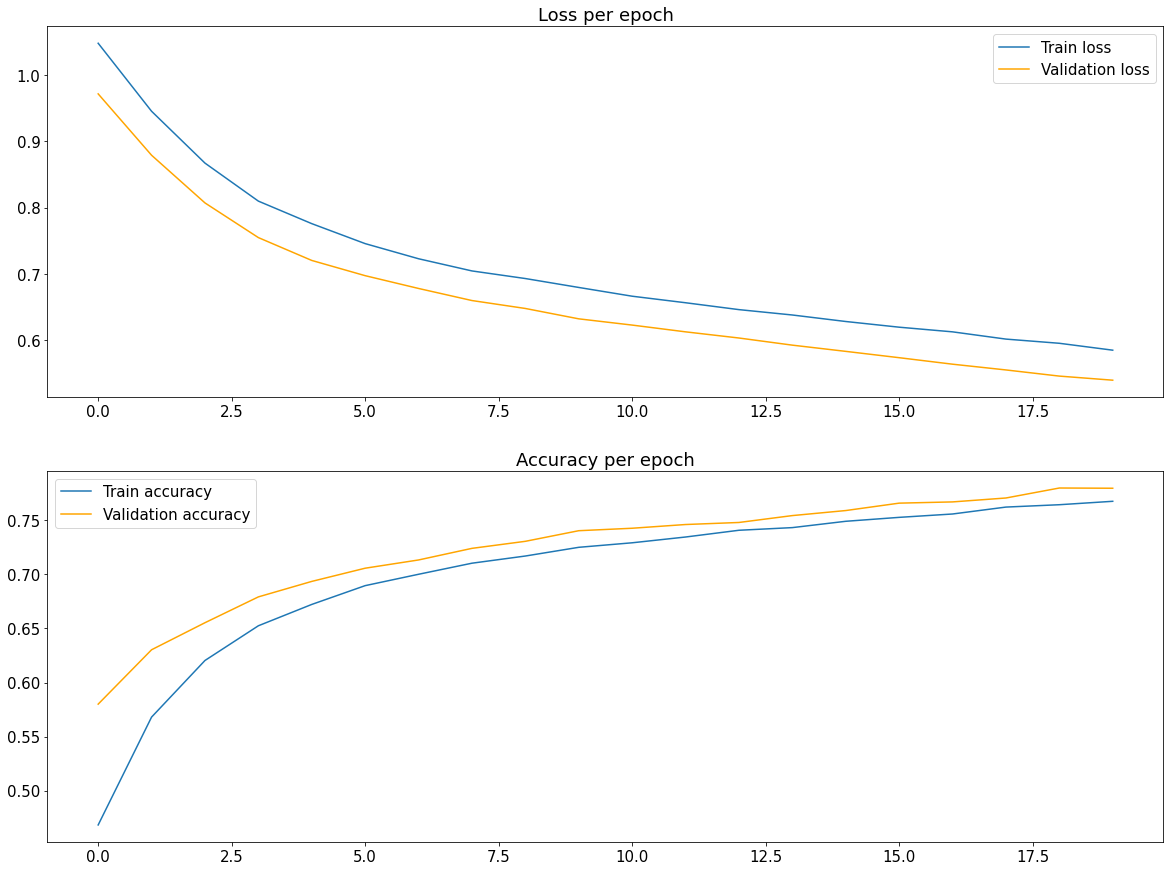

In [26]:
def plot(loss_list, acc_list, EPOCHS):
    
    fig = plt.figure(figsize=(20,15))
    
    fig.add_subplot(2,1,1)
    plt.title("Loss per epoch")
    plt.plot(range(EPOCHS), loss_list["train"], label = "Train loss")
    plt.plot(range(EPOCHS), loss_list["val"], color = "orange", label = "Validation loss")
    plt.legend()
    
    fig.add_subplot(2,1,2)
    plt.title("Accuracy per epoch")
    plt.plot(range(EPOCHS), acc_list["train"], label = "Train accuracy")
    plt.plot(range(EPOCHS), acc_list["val"], color = "orange", label = "Validation accuracy")
    plt.legend()

if TRAIN_DATA:
    plot(loss_list, acc_list, EPOCHS)

In [27]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence, sentiment, min_len = 5):
    
    
    if len(sentence.split()<=3) or sentiment == "neutral":
        return sentence
    
    
    model.eval()
    label = LABEL.vocab.stoi[sentiment]
    
    threshhold = [0.5,0.7,0.7]
    sentence_split = sentence.split()
    print(sentence_split)
    tokenized = [mytokenizer(i,train=False)[0] for i in sentence_split]
    print(tokenized)
    
    start = 0
    end = len(tokenized)-1
    
    result = []
    with torch.no_grad():
        for idx,token in enumerate(tokenized):
            token = [token]
            if len(token) < min_len:
                token += ['<pad>'] * (min_len - len(token))

            indexed = [TEXT.vocab.stoi[t] for t in token]
            tensor = torch.LongTensor(indexed).to(device)
            tensor = tensor.unsqueeze(0)
            prediction = torch.softmax(model(tensor), dim=1)
           
            result.append(prediction[0][label].cpu().numpy())
            
    result = np.array(result)
    print(result)
    
    most_weighted = result > threshhold[label]
    flag = 0
    for idx,i in enumerate(most_weighted):
        if i:
            if flag == 0:
                start = idx
                end = idx
                flag = 1
            else:
                end = idx
 
    return " ".join(sentence_split[start:end+1])

In [33]:
text = 'wtf come i need this day to go by'
sentiment = "negative"
predict_sentiment(model, text, sentiment)

['wtf', 'come', 'i', 'need', 'this', 'day', 'to', 'go', 'by']
['wtf', 'come', 'i', 'need', 'this', 'day', 'to', 'go', 'by']
[0.9948468  0.11326396 0.07320248 0.109858   0.07320248 0.12578498
 0.07320248 0.07489612 0.07320248]


'wtf'

In [29]:
import csv
def predict(model):
    with open("data/test.csv") as fi, open("data/submission.csv", "w", newline = "") as fo:
        reader = csv.reader(fi)
        writer = csv.writer(fo)
        header = next(iter(reader))
        writer.writerow(header)
        for row in tqdm(reader):
            idx, sentence, sentiment = row
            target = predict_sentiment(model,sentence,sentiment)
            writer.writerow([idx] + [target])
        print("Writing Completed!")

In [30]:
predict(model)

['Last', 'session', 'of', 'the', 'day', 'http://twitpic.com/67ezh']
['last', 'session', 'of', 'the', 'day', '<unk>']
[0.7296508  0.6519102  0.56240726 0.56240726 0.7154051  0.56240726]
['Shanghai', 'is', 'also', 'really', 'exciting', '(precisely', '--', 'skyscrapers', 'galore).', 'Good', 'tweeps', 'in', 'China:', '(SH)', '(BJ).']
['shanghai', 'is', 'also', 'really', 'exciting', 'precisely', '<unk>', 'skyscraper', 'galore', 'good', 'tweeps', 'in', 'china', 'sh', 'bj']
[0.20823187 0.21209157 0.15072584 0.18075147 0.9423217  0.19319543
 0.21209157 0.21209157 0.24455288 0.8801822  0.06635354 0.21209157
 0.24217325 0.14506218 0.21379732]
['Recession', 'hit', 'Veronique', 'Branquinho,', 'she', 'has', 'to', 'quit', 'her', 'company,', 'such', 'a', 'shame!']
['recession', 'hit', 'veronique', 'branquinho', 'she', 'ha', 'to', 'quit', 'her', 'company', 'such', 'a', 'shame']
[0.714619   0.23829709 0.30422574 0.2372699  0.2255012  0.1357694
 0.2255012  0.24430996 0.2255012  0.15719202 0.2255012  0.2

[0.78215206 0.56240726 0.58068556 0.56240726 0.56240726 0.56240726
 0.7375557  0.56240726 0.56240726 0.56240726 0.56240726 0.65375024]
['resorted', 'to', 'eating', 'Mickey', 'Ds', 'ALONE.']
['resorted', 'to', 'eating', 'mickey', 'd', 'alone']
[0.52892536 0.56240726 0.690248   0.6070693  0.56240726 0.6729565 ]
['There', 'is', 'a', 'faux', 'gothy', 'chick', 'looking', 'at', 'me,', 'sorry', 'I', 'am', 'not', 'going', 'to', 'camden', 'and', 'I', 'like', 'pop-punk', 'and', 'jimmy', 'eat', 'world']
['there', 'is', 'a', 'faux', 'gothy', 'chick', 'looking', 'at', 'me', 'sorry', 'i', 'am', 'not', 'going', 'to', 'camden', 'and', 'i', 'like', 'pop', 'and', 'jimmy', 'eat', 'world']
[0.56240726 0.56240726 0.56240726 0.54780376 0.8248027  0.6110142
 0.65882444 0.56240726 0.56240726 0.04861294 0.56240726 0.56240726
 0.56240726 0.78332406 0.56240726 0.5610332  0.56240726 0.56240726
 0.6278772  0.6624045  0.56240726 0.6012748  0.7166874  0.5701706 ]
['did', 'he', 'ask', 'for', 'your', 'Twitter', 'ID?',

[0.71035105 0.7415888  0.56240726 0.59153503 0.67901856 0.56240726
 0.56240726 0.7453225  0.56240726]
['reality', 'needs', 'to', 'check', 'in.', 'schools', 'over.', 'time', 'to', 'party', 'not', 'tonight', 'tho,', 'im', 'going', 'to', 'bed.', 'night,', 'night.']
['reality', 'need', 'to', 'check', 'in', 'school', 'over', 'time', 'to', 'party', 'not', 'tonight', 'tho', 'im', 'going', 'to', 'bed', 'night', 'night']
[0.5851165  0.707114   0.56240726 0.7828786  0.56240726 0.7228621
 0.56240726 0.7773613  0.56240726 0.66387814 0.56240726 0.69600713
 0.4764109  0.65328294 0.78332406 0.56240726 0.75287014 0.7526363
 0.7526363 ]
['Caladesi', 'was', 'definitely', 'a', 'nice', 'peaceful', 'way', 'to', 'spend', 'a', 'Sunday!', 'I', 'got', 'a', 'lil', 'tan!']
['caladesi', 'wa', 'definitely', 'a', 'nice', 'peaceful', 'way', 'to', 'spend', 'a', 'sunday', 'i', 'got', 'a', 'lil', 'tan']
[0.25972027 0.1739957  0.483069   0.21209157 0.9484172  0.62743956
 0.13354039 0.21209157 0.14390789 0.21209157 0.162

[0.2255012  0.7257518  0.2255012  0.2255012  0.17951885 0.15750125]
['http://twitpic.com/4wp8s', '-', 'My', 'ear', 'hurts,', 'and', 'THIS', 'is', 'my', 'medicine.', 'GUM']
['<unk>', '<unk>', 'my', 'ear', 'hurts', 'and', 'this', 'is', 'my', 'medicine', 'gum']
[0.2255012  0.2255012  0.2255012  0.23052508 0.974719   0.2255012
 0.2255012  0.2255012  0.2255012  0.2277507  0.20357539]
['_berland', 'LMAO', 'I', 'know', 'I', 'know']
['berland', 'lmao', 'i', 'know', 'i', 'know']
[0.5814825  0.4732924  0.56240726 0.80488837 0.56240726 0.80488837]
['Gnight', 'shar', '<(`', '`<)Vega(>`', '`)>']
['gnight', 'shar', '<unk>', '<unk>', '<unk>']
[0.2507126  0.5860188  0.56240726 0.56240726 0.56240726]
['The', 'underwire', 'in', 'my', 'bra', 'is', 'sticking', 'out', 'and', 'poking', 'me', 'in', 'the', 'armpit']
['the', 'underwire', 'in', 'my', 'bra', 'is', 'sticking', 'out', 'and', 'poking', 'me', 'in', 'the', 'armpit']
[0.2255012  0.26193014 0.2255012  0.2255012  0.19243473 0.2255012
 0.24869415 0.22550

[0.78469986 0.21209157 0.10819418 0.21209157]
['bahah', 'sadly', 'I', 'am', 'not']
['bahah', 'sadly', 'i', 'am', 'not']
[0.18676607 0.96142167 0.2255012  0.2255012  0.2255012 ]
['i', 'always', 'have', 'those', 'for', 'my', 'Champions', 'League', 'parties', 'Tis', 'awesome']
['i', 'always', 'have', 'those', 'for', 'my', 'champion', 'league', 'party', 'ti', 'awesome']
[0.21209157 0.25982738 0.21209157 0.21209157 0.21209157 0.21209157
 0.2511298  0.1511922  0.17122193 0.19891138 0.9825737 ]
['well,', 'not', 'all.', 'just', 'stay', 'away', 'from', 'those', 'kinds', 'and', 'surround', 'yourself', 'with', 'those', 'who', 'don`t.', 'happy', 'mother`s', 'day', 'to', 'ur', 'mom,', 'treiz!']
['well', 'not', 'all', 'just', 'stay', 'away', 'from', 'those', 'kind', 'and', 'surround', 'yourself', 'with', 'those', 'who', 'don', 'happy', 'mother', 'day', 'to', 'ur', 'mom', 'treiz']
[0.18102252 0.21209157 0.21209157 0.21209157 0.14177284 0.08566662
 0.21209157 0.21209157 0.4440252  0.21209157 0.2163108

[0.24439384 0.595954   0.2255012  0.2255012  0.17814037 0.2255012
 0.8216348  0.2255012  0.1130503 ]
['well', 'thank', 'your', 'phone', 'for', 'me.']
['well', 'thank', 'your', 'phone', 'for', 'me']
[0.18102252 0.97439486 0.21209157 0.07275148 0.21209157 0.21209157]
['why', 'would', 'they', 'take', 'a', 'photo', 'with', 'stuffed', 'animals?!', 'that`s', 'pretty', 'funny']
['why', 'would', 'they', 'take', 'a', 'photo', 'with', 'stuffed', 'animals', 'that', 'pretty', 'funny']
[0.21209157 0.12751453 0.21209157 0.13086069 0.21209157 0.13164006
 0.21209157 0.15767461 0.21825826 0.21209157 0.6606946  0.88168365]
['TweetDeck', 'is', 'acting', 'really', 'strange!', 'Hum........', 'reinstall', 'maybe.', 'Update', 'on', 'the', 'horizon?', 'Or', 'is', 'it', 'just', 'another', 'Adobe', 'memory', 'leak']
['tweetdeck', 'is', 'acting', 'really', 'strange', 'hum', 'reinstall', 'maybe', 'update', 'on', 'the', 'horizon', 'or', 'is', 'it', 'just', 'another', 'adobe', 'memory', 'leak']
[0.4624472  0.562407

 0.6146155  0.56240726 0.32747197]
['E.L.O.', 'wow,', 'brings', 'back', 'so', 'many', 'happy', 'memories.', 'LOVE', 'this', 'band!..and', 'yes,', 'I', 'know', 'I`m', 'showing', 'my', 'age', 'but', 'I', 'don`t', 'care']
['e', 'wow', 'brings', 'back', 'so', 'many', 'happy', 'memories', 'love', 'this', 'band', 'yes', 'i', 'know', 'i', 'showing', 'my', 'age', 'but', 'i', 'don', 'care']
[0.12149688 0.63674176 0.30636224 0.09584635 0.21209157 0.12881361
 0.94013697 0.47522214 0.9492957  0.21209157 0.14787893 0.19737124
 0.21209157 0.08667719 0.21209157 0.15613323 0.21209157 0.12959857
 0.21209157 0.21209157 0.21209157 0.21729925]
['that`s', 'a', 'very', 'cute', 'picture', '...', 'but', 'you', 'don`t', 'get', 'fat', 'from', 'licking', 'BBQs', '...', 'he', 'must', 'have', 'found', 'some', 'chops', 'on', 'someone', 'else`s', '...']
['that', 'a', 'very', 'cute', 'picture', '<unk>', 'but', 'you', 'don', 'get', 'fat', 'from', 'licking', 'bbqs', '<unk>', 'he', 'must', 'have', 'found', 'some', 'chop

[0.02756981 0.2255012  0.22210145 0.1879799  0.2255012  0.39171505
 0.2255012  0.18446113 0.25997096 0.20970266 0.8216348 ]
['Yup', 'theory', 'is', 'GREAT', 'but', 'the', 'reality', 'is', 'beyond', 'imagination...', 'I', 'also', 'made', 'the', 'same', 'planning', 'not', 'knowing', 'VS', 'will', 'FAIL', 'on', 'me']
['yup', 'theory', 'is', 'great', 'but', 'the', 'reality', 'is', 'beyond', 'imagination', 'i', 'also', 'made', 'the', 'same', 'planning', 'not', 'knowing', 'v', 'will', 'fail', 'on', 'me']
[0.65828156 0.66277725 0.56240726 0.0412377  0.56240726 0.56240726
 0.5851165  0.56240726 0.61328864 0.43555066 0.56240726 0.6772637
 0.706884   0.56240726 0.56240726 0.67501575 0.56240726 0.55796915
 0.6248701  0.56240726 0.08257817 0.56240726 0.56240726]
['glad', 'to', 'know', 'that', 'the', 'ad', 'display', 'problem', 'was', 'due', 'to', 'a', 'firewall', 'config', 'at', 'yr', 'office.', 'phew!']
['glad', 'to', 'know', 'that', 'the', 'ad', 'display', 'problem', 'wa', 'due', 'to', 'a', 'fir

[0.2255012  0.2255012  0.2154956  0.28263497 0.2255012  0.18365914]
['Be', 'sure', 'to', 'let', 'the', 'moms', 'you', 'know', 'how', 'fabulous', 'you', 'think', 'they', 'are!!', 'Almost', 'Mother`s', 'Day.']
['be', 'sure', 'to', 'let', 'the', 'mom', 'you', 'know', 'how', 'fabulous', 'you', 'think', 'they', 'are', 'almost', 'mother', 'day']
[0.21209157 0.18337284 0.21209157 0.11181267 0.21209157 0.24257179
 0.21209157 0.08667719 0.21209157 0.9307104  0.21209157 0.10477732
 0.21209157 0.21209157 0.10070106 0.25134435 0.13863088]
['_in_a_story', 'Glad', 'I`m', 'not', 'the', 'only', 'one.', 'He`s', 'our', 'baby,', 'and', 'I`m', 'terrified', 'he`ll', 'think', 'we`re', 'never', 'coming', 'back.']
['in', 'glad', 'i', 'not', 'the', 'only', 'one', 'he', 'our', 'baby', 'and', 'i', 'terrified', 'he', 'think', 'we', 'never', 'coming', 'back']
[0.56240726 0.04699276 0.56240726 0.56240726 0.56240726 0.56240726
 0.7373462  0.56240726 0.56240726 0.66410226 0.56240726 0.56240726
 0.2568836  0.56240726 

 0.56240726 0.6011518  0.7154051 ]
['Hey!', 'That`s', 'my', 'school!', 'I', 'hate', 'that', 'place.']
['hey', 'that', 'my', 'school', 'i', 'hate', 'that', 'place']
[0.08757084 0.2255012  0.2255012  0.16425616 0.2255012  0.9500431
 0.2255012  0.18091847]
['i', 'did', 'i', 'only', 'got', '3', 'stars', 'on', 'the', 'pre', 'wash', 'then', 'failed', 'the', 'rince']
['i', 'did', 'i', 'only', 'got', '<unk>', 'star', 'on', 'the', 'pre', 'wash', 'then', 'failed', 'the', 'rince']
[0.2255012  0.2255012  0.2255012  0.2255012  0.14547879 0.2255012
 0.10469785 0.2255012  0.2255012  0.19845606 0.22473586 0.2255012
 0.7336451  0.2255012  0.35886475]
['MY', 'SiSTER', 'iN', 'LAW', 'JUST', 'LEFT', 'FOR', 'HER', 'PROM!!', 'SHE', 'LOOKED', 'SOO', 'PRETTY..', 'TEARS', 'ALL', 'AROUND']
['my', 'sister', 'in', 'law', 'just', 'left', 'for', 'her', 'prom', 'she', 'looked', 'soo', 'pretty', 'tear', 'all', 'around']
[0.21209157 0.18695891 0.21209157 0.14180659 0.21209157 0.06976906
 0.21209157 0.21209157 0.2043873

[0.13616344 0.06140928 0.2255012  0.8340661  0.19411002 0.13616344
 0.2722582  0.21570528 0.26142505 0.22754969 0.17003922]
['09/09', '+full', 'moon+', 'my', 'lovely', 'friends', 'and', 'family=', 'my', 'b-day', 'wish', 'came', 'true;)<3', 'In', 'addition,gray', 'matters', 'is', 'one', 'of', 'the', 'cutest', 'movies', 'ever!!']
['<unk>', 'full', 'moon', 'my', 'lovely', 'friend', 'and', 'family', 'my', 'b', 'wish', 'came', 'true', 'in', 'addition', 'matter', 'is', 'one', 'of', 'the', 'cutest', 'movie', 'ever']
[0.21209157 0.16153006 0.20398827 0.21209157 0.9692544  0.16489275
 0.21209157 0.18574798 0.21209157 0.15290703 0.73500794 0.13838714
 0.5769958  0.21209157 0.1874409  0.11496143 0.21209157 0.10453606
 0.21209157 0.21209157 0.59764725 0.1726693  0.18832766]
['My', 'Life', 'Would', 'Suck', 'Without', 'You', '-', 'Kelly', 'Clarkson']
['my', 'life', 'would', 'suck', 'without', 'you', '<unk>', 'kelly', 'clarkson']
[0.2255012  0.28467333 0.13616344 0.8828148  0.25145775 0.2255012
 0.22

 0.21209157 0.21209157 0.13354039 0.21209157]
['ok.', 'lol.', 'i', 'miss', 'you', 'too.', 'i', 'hope', 'your', 'cramps', 'get', 'better.', 'i', 'know', 'how', 'painful', 'they', 'can', 'be.']
['ok', 'lol', 'i', 'miss', 'you', 'too', 'i', 'hope', 'your', 'cramp', 'get', 'better', 'i', 'know', 'how', 'painful', 'they', 'can', 'be']
[0.752634   0.63510656 0.56240726 0.06450418 0.56240726 0.56240726
 0.56240726 0.12592344 0.56240726 0.39722034 0.7574958  0.28831956
 0.56240726 0.80488837 0.56240726 0.05957234 0.56240726 0.56240726
 0.56240726]
['Oh,', 'and', 'a', 'very', 'good', 'review']
['oh', 'and', 'a', 'very', 'good', 'review']
[0.12722652 0.21209157 0.21209157 0.21209157 0.8801822  0.1654081 ]
['_MileyCyrus', 'it', 'wont', 'let', 'me', 'do', 'it', 'twitter', 'keeps', 'saying', 'over', 'twitter', 'capacity', 'or', 'something', 'that', 'bird', 'keeps', 'coming', 'up.']
['mileycyrus', 'it', 'wont', 'let', 'me', 'do', 'it', 'twitter', 'keep', 'saying', 'over', 'twitter', 'capacity', 'or'

[0.91960114 0.2255012  0.31879994 0.12374584 0.2255012 ]
['Download', 'movie', "'A", 'Good', 'Day', 'to', 'Be', 'Black', '&#38', "Sexy'", 'http://tinyurl.com/ckmkul', 'cool', '#movie']
['download', 'movie', 'a', 'good', 'day', 'to', 'be', 'black', '<unk>', 'sexy', '<unk>', 'cool', 'movie']
[0.13418262 0.1726693  0.21209157 0.8801822  0.13863088 0.21209157
 0.21209157 0.14435741 0.21209157 0.46548006 0.21209157 0.8235715
 0.1726693 ]
['Jus', 'got', 'back', 'from', 'a', 'run', 'up', 'sunset', 'blvd!', 'My', 'cuzin', 'tried', 'to', 'kill', 'me', 'my', 'legs', 'are', 'still', 'movin', 'and', 'I`m', 'sittin', 'down!!']
['jus', 'got', 'back', 'from', 'a', 'run', 'up', 'sunset', 'blvd', 'my', 'cuzin', 'tried', 'to', 'kill', 'me', 'my', 'leg', 'are', 'still', 'movin', 'and', 'i', 'sittin', 'down']
[0.2026125  0.14547879 0.1244591  0.2255012  0.2255012  0.16945316
 0.2255012  0.16211943 0.20620558 0.2255012  0.41862273 0.25283143
 0.2255012  0.59225065 0.2255012  0.2255012  0.542248   0.2255012

[0.7916726  0.51118886 0.51118886 0.7458689 ]
['Headed', 'home', '...', 'Charlie`s', 'at', 'the', 'vet']
['headed', 'home', '<unk>', 'charlie', 'at', 'the', 'vet']
[0.59591055 0.71912175 0.56240726 0.6480069  0.56240726 0.56240726
 0.5396618 ]
['i', 'wanna', 'b', 'maliks', 'from', 'taking', 'the', 'stage']
['i', 'wanna', 'b', 'malik', 'from', 'taking', 'the', 'stage']
[0.56240726 0.58285046 0.6836086  0.56240726 0.56240726 0.65809846
 0.56240726 0.69176775]
['is', 'going', 'to', 'bed', 'soon.', 'happy', 'mothers', 'day', 'to', 'all', 'the', 'mothers', '<333', 'ryan', 'less', 'than', '3', 'weeks', ':]']
['is', 'going', 'to', 'bed', 'soon', 'happy', 'mother', 'day', 'to', 'all', 'the', 'mother', '<unk>', 'ryan', 'le', 'than', '<unk>', 'week', '<unk>']
[0.21209157 0.08233445 0.21209157 0.1196325  0.1250875  0.94013697
 0.25134435 0.13863088 0.21209157 0.21209157 0.21209157 0.25134435
 0.21209157 0.17835099 0.14449991 0.21209157 0.21209157 0.1083881
 0.21209157]
['bored', 'bored', 'bored!'

 0.56240726 0.62580836 0.56240726 0.6851665  0.68689764]
['I', 'love', 'very', 'much', 'I', 'called', 'him,', 'but', 'he', 'was', 'talking', 'to', 'other', 'fans', 'I', 'love', 'you', 'a', 'lot', 'Mitchel!', 'I`ll', 'see', 'u', 'in', 'El', 'Cajon.', 'June', '7']
['i', 'love', 'very', 'much', 'i', 'called', 'him', 'but', 'he', 'wa', 'talking', 'to', 'other', 'fan', 'i', 'love', 'you', 'a', 'lot', 'mitchel', 'i', 'see', 'u', 'in', 'el', 'cajon', 'june', '<unk>']
[0.21209157 0.9492957  0.21209157 0.13595814 0.21209157 0.14346865
 0.21209157 0.21209157 0.21209157 0.1739957  0.11290113 0.21209157
 0.21209157 0.26804328 0.21209157 0.9492957  0.21209157 0.21209157
 0.17001526 0.22675207 0.21209157 0.12771066 0.14465256 0.21209157
 0.17289515 0.18217313 0.12862387 0.21209157]
['I', 'misses', 'my', 'bed', 'so', 'sleepy!']
['i', 'miss', 'my', 'bed', 'so', 'sleepy']
[0.2255012  0.9310255  0.2255012  0.12749729 0.2255012  0.45545274]
['Woo!', 'Two', 'days', 'till', 'awesome', 'gig,', 'one', 'day',

[0.56240726 0.6158906  0.56240726 0.56240726 0.56240726 0.56240726
 0.56240726 0.6822012  0.4858802  0.7215087 ]
['Cant', 'wait', 'for', 'DTE', 'in', 'Michigan', 'this', 'summer', 'you', 'guys', 'are', 'great', 'look', 'for', 'me', 'in', 'the', 'customized', 'NKOTB', 'Track', 'Jacket']
['cant', 'wait', 'for', 'dte', 'in', 'michigan', 'this', 'summer', 'you', 'guy', 'are', 'great', 'look', 'for', 'me', 'in', 'the', 'customized', 'nkotb', 'track', 'jacket']
[0.06265525 0.22813037 0.21209157 0.27375385 0.21209157 0.15855105
 0.21209157 0.13326776 0.21209157 0.21829434 0.21209157 0.95459735
 0.13428564 0.21209157 0.21209157 0.21209157 0.21209157 0.24146916
 0.5668726  0.15976115 0.14451398]
['nope', 'i', 'have', 'a', 'fifth', 'generation', 'ipod', 'classic', 'it', 'likes', 'to', 'be', 'dumb']
['nope', 'i', 'have', 'a', 'fifth', 'generation', 'ipod', 'classic', 'it', 'like', 'to', 'be', 'dumb']
[0.24917102 0.2255012  0.2255012  0.2255012  0.2587689  0.21838757
 0.17509806 0.14045912 0.22550

[0.21209157 0.18337284 0.21209157 0.21209157]
['Getting', 'ready', 'for', 'work', 'and', 'the', 'sun', 'is', 'shining,', 'plus', 'it`s', 'the', 'w/e!', 'Bgt', 'tonight.....', 'what', 'am', 'I', 'gonna', 'do', 'after', 'it`s', 'finished?!']
['getting', 'ready', 'for', 'work', 'and', 'the', 'sun', 'is', 'shining', 'plus', 'it', 'the', 'w', 'bgt', 'tonight', 'what', 'am', 'i', 'gonna', 'do', 'after', 'it', 'finished']
[0.6705004  0.74117225 0.56240726 0.7453225  0.56240726 0.56240726
 0.71906394 0.56240726 0.331892   0.6576873  0.56240726 0.56240726
 0.63377196 0.5268241  0.69600713 0.56240726 0.56240726 0.56240726
 0.6785749  0.56240726 0.56240726 0.56240726 0.74429196]
['this', 'aztec', 'mask', 'is', 'harder', 'then', 'i', 'thought!', 'but', 'u', 'kno', 'what,', 'i', 'think', 'i', 'did', 'a', 'pretty', 'good', 'job', 'for', 'not', 'being', 'an', 'artist']
['this', 'aztec', 'mask', 'is', 'harder', 'then', 'i', 'thought', 'but', 'u', 'kno', 'what', 'i', 'think', 'i', 'did', 'a', 'pretty',

[0.2255012  0.24578522 0.2255012  0.26257482 0.9310255  0.20718513
 0.2255012  0.1244591  0.15726161]
['Going', 'to', 'bed', 'after', 'the', 'CAVS', 'game', 'Don`t', 'judge', 'me', 'LOL']
['going', 'to', 'bed', 'after', 'the', 'cavs', 'game', 'don', 'judge', 'me', 'lol']
[0.78332406 0.56240726 0.75287014 0.56240726 0.56240726 0.5653669
 0.73234814 0.56240726 0.6599566  0.56240726 0.63510656]
['you`re', 'a', 'busy', 'Bob,', 'I`m', 'jealous.', 'I`m', 'not', 'sure', 'I', 'can', 'even', 'afford', 'to', 'go', 'meet', 'John', 'de', 'Lancie', 'and', 'Leonard', 'Nimoy']
['you', 'a', 'busy', 'bob', 'i', 'jealous', 'i', 'not', 'sure', 'i', 'can', 'even', 'afford', 'to', 'go', 'meet', 'john', 'de', 'lancie', 'and', 'leonard', 'nimoy']
[0.2255012  0.2255012  0.19172347 0.17640394 0.2255012  0.9511424
 0.2255012  0.2255012  0.1270376  0.2255012  0.2255012  0.28955352
 0.6740089  0.2255012  0.12374584 0.16268924 0.1689295  0.1231942
 0.23750012 0.2255012  0.18410286 0.19404288]
['I', 'am', 'living',

 0.2876681  0.21209157 0.21209157 0.20036903]
['found', 'a', 'swing', 'set', 'for', 'sale', '2', 'blocks', 'from', 'home,', 'super', 'cheap.', 'I', 'want', 'it', '4', 'my', 'kids', 'but', 'no', 'one', 'is', 'answering', 'the', 'phone', '#', 'listed']
['found', 'a', 'swing', 'set', 'for', 'sale', '<unk>', 'block', 'from', 'home', 'super', 'cheap', 'i', 'want', 'it', '<unk>', 'my', 'kid', 'but', 'no', 'one', 'is', 'answering', 'the', 'phone', '<unk>', 'listed']
[0.7090533  0.56240726 0.59754133 0.6956704  0.56240726 0.69303906
 0.56240726 0.64586693 0.56240726 0.71912175 0.56932974 0.42951846
 0.56240726 0.7375557  0.56240726 0.56240726 0.56240726 0.510793
 0.56240726 0.56240726 0.7373462  0.56240726 0.680926   0.56240726
 0.8141982  0.56240726 0.63225925]
['So', 'many', 'farewell', 'parties!', 'sad', 'to', 'see', 'people', 'leaving', '..']
['so', 'many', 'farewell', 'parties', 'sad', 'to', 'see', 'people', 'leaving', '<unk>']
[0.2255012  0.20496666 0.1592067  0.18393683 0.9739498  0.225

[0.11971784 0.21209157 0.09712144 0.8801822  0.13863088 0.21209157
 0.21209157 0.14449991 0.15826504 0.48411962 0.07847799 0.21209157
 0.26804328 0.21209157 0.21209157 0.21209157 0.11573317 0.10663935
 0.21209157 0.21209157]
['i', 'was', 'going', 'tonight,', 'but', 'you', 'never', 'wrote', 'me', 'back', 'with', 'the', 'info', 'im', 'sososo', 'sad...']
['i', 'wa', 'going', 'tonight', 'but', 'you', 'never', 'wrote', 'me', 'back', 'with', 'the', 'info', 'im', 'sososo', 'sad']
[0.2255012  0.22210145 0.13434143 0.16001828 0.2255012  0.2255012
 0.272702   0.16437185 0.2255012  0.1244591  0.2255012  0.2255012
 0.17502771 0.24439384 0.32486773 0.9739498 ]
['still', 'not', '100%', 'im', 'sick', 'of', 'being', 'sick!']
['still', 'not', '<unk>', 'im', 'sick', 'of', 'being', 'sick']
[0.17108247 0.2255012  0.2255012  0.24439384 0.94458914 0.2255012
 0.2255012  0.94458914]
['_collins', 'I`m', 'not', 'sure', 'I', 'understand', 'how', 'this', 'twitter', 'thing', 'works...']
['collins', 'i', 'not', 'su

[0.57222563 0.56240726 0.56240726 0.6322141  0.56240726 0.07899182
 0.6013862  0.56240726 0.22444318 0.56240726 0.56240726 0.56240726
 0.56240726 0.56240726 0.56240726 0.6692288  0.18591097]
['Good', 'morning.', 'haha', 'I', 'just', 'read', 'that', 'the', 'swine', 'flu', 'probably', 'not', 'come`s', 'from', 'pigs', 'at', 'all,', 'but', 'from', 'people!', 'Poor', 'pigs', 'who', 'got', 'all', 'the', 'blame!']
['good', 'morning', 'haha', 'i', 'just', 'read', 'that', 'the', 'swine', 'flu', 'probably', 'not', 'come', 'from', 'pig', 'at', 'all', 'but', 'from', 'people', 'poor', 'pig', 'who', 'got', 'all', 'the', 'blame']
[0.09391976 0.7916726  0.36981443 0.56240726 0.56240726 0.7873879
 0.56240726 0.56240726 0.57228947 0.6148599  0.714239   0.56240726
 0.7134849  0.56240726 0.56701165 0.56240726 0.56240726 0.56240726
 0.56240726 0.67817074 0.04055919 0.56701165 0.56240726 0.7415888
 0.56240726 0.56240726 0.15778351]
['Is', 'bummed', 'out...i', 'don`t', 'have', 'even', 'one', 'testimonial', '

[0.76221967 0.5912988  0.7574958  0.56240726 0.5280012  0.56240726
 0.56240726 0.56240726 0.6825408  0.5110128  0.7574958  0.56240726
 0.61070037 0.56240726 0.3943985 ]
['_eat_out']
['eat']
[0.7166874]
['Thanks,', 'hope', 'you', 'have', 'a', 'good', 'one']
['thanks', 'hope', 'you', 'have', 'a', 'good', 'one']
[0.9738583  0.8631059  0.21209157 0.21209157 0.21209157 0.8801822
 0.10453606]
['-', 'You', 'too,', 'thanks', 'for', 'completing', 'Calvin', 'Appreciated']
['<unk>', 'you', 'too', 'thanks', 'for', 'completing', 'calvin', 'appreciated']
[0.21209157 0.21209157 0.21209157 0.9738583  0.21209157 0.18311366
 0.1638536  0.89677596]
['Morning', 'everyone', 'sorry', 'for', 'going', 'early', 'last', 'night', 'had', 'bad', 'news,', 'felt', 'totally', '****', 'Today', 'is', 'a', 'new', 'day']
['morning', 'everyone', 'sorry', 'for', 'going', 'early', 'last', 'night', 'had', 'bad', 'news', 'felt', 'totally', '*', 'today', 'is', 'a', 'new', 'day']
[0.09601898 0.14303696 0.9484959  0.2255012  0.1

[0.23280354 0.22754969 0.2255012  0.2255012  0.2255012  0.31879994
 0.2255012  0.12374584 0.2255012  0.2255012  0.2255012  0.2255012
 0.16268924 0.2891286  0.2255012  0.24439384 0.2255012  0.33209744
 0.2255012  0.2255012  0.34269893]
['I', 'need', 'a', 'bear', 'hug', 'and', 'Im', 'going', 'to', 'camp', 'today!!']
['i', 'need', 'a', 'bear', 'hug', 'and', 'im', 'going', 'to', 'camp', 'today']
[0.56240726 0.707114   0.56240726 0.59399337 0.41461387 0.56240726
 0.65328294 0.78332406 0.56240726 0.64603466 0.72278094]
['If', 'I', 'could,', 'I`d', 'send', 'California', 'sunshine', 'your', 'way.']
['if', 'i', 'could', 'i', 'send', 'california', 'sunshine', 'your', 'way']
[0.21209157 0.21209157 0.13094962 0.21209157 0.15776032 0.16296053
 0.34960067 0.21209157 0.13354039]
['I', 'need', 'a', 'present', 'for', 'my', 'mom.', 'Could', 'anybody', 'help', 'me', '?!']
['i', 'need', 'a', 'present', 'for', 'my', 'mom', 'could', 'anybody', 'help', 'me', '<unk>']
[0.21209157 0.13763098 0.21209157 0.19690

['I', 'don`t', 'even', 'look', 'at', 'their', 'fabric', 'unless', 'I', 'need', 'polar', 'fleece.', 'It`s', 'worth', 'the', 'extra', '$', 'to', 'go', 'to', 'Needle', 'and', 'Thread.']
['i', 'don', 'even', 'look', 'at', 'their', 'fabric', 'unless', 'i', 'need', 'polar', 'fleece', 'it', 'worth', 'the', 'extra', '<unk>', 'to', 'go', 'to', 'needle', 'and', 'thread']
[0.56240726 0.56240726 0.6196562  0.708834   0.56240726 0.56240726
 0.57931966 0.61136687 0.56240726 0.707114   0.54627144 0.5258654
 0.56240726 0.5289257  0.56240726 0.654925   0.56240726 0.56240726
 0.7838106  0.56240726 0.6207868  0.56240726 0.62485313]
['Pleeaaasee', 'come', 'out', 'sun']
['pleeasee', 'come', 'out', 'sun']
[0.61672956 0.7134849  0.56240726 0.71906394]
['ummm...last', 'night', 'when', 'I', 'DM`d', 'you,', 'you', 'said', 'it', 'was', 'a', "'good'", 'question.']
['um', 'night', 'when', 'i', 'dm', 'you', 'you', 'said', 'it', 'wa', 'a', 'good', 'question']
[0.11748867 0.12942259 0.21209157 0.21209157 0.18134217 0

 0.21209157]
['shake', 'shake', 'shake', 'shake', 'shake', 'it']
['shake', 'shake', 'shake', 'shake', 'shake', 'it']
[0.5763251  0.5763251  0.5763251  0.5763251  0.5763251  0.56240726]
['Raining', 'again']
['raining', 'again']
[0.7125272  0.56240726]
['good', 'morning', 'world']
['good', 'morning', 'world']
[0.8801822  0.11230837 0.22841294]
['i', 'hope', 'that', 'everyone', 'has', 'been', 'having', 'a', 'great', 'week.', 'let', 'me', 'know', 'if', 'you', 'think', 'im', 'crazy', 'for', 'hating', 'coffee', 'XD.']
['i', 'hope', 'that', 'everyone', 'ha', 'been', 'having', 'a', 'great', 'week', 'let', 'me', 'know', 'if', 'you', 'think', 'im', 'crazy', 'for', 'hating', 'coffee', 'xd']
[0.56240726 0.12592344 0.56240726 0.6624473  0.6972535  0.56240726
 0.56240726 0.56240726 0.0412377  0.7486189  0.72059554 0.56240726
 0.80488837 0.56240726 0.56240726 0.7484174  0.65328294 0.40575224
 0.56240726 0.25120404 0.7361531  0.3380096 ]
['back', 'to', 'br']
['back', 'to', 'br']
[0.77969444 0.56240726

[0.21209157 0.19061674 0.21209157 0.21209157 0.56117517 0.21209157
 0.21209157 0.13595814 0.21209157 0.09281626 0.21209157 0.14390789
 0.22190164 0.18882363 0.21209157 0.17892492 0.21209157 0.21209157
 0.8801822  0.20999591]
['On', 'the', 'phone', 'to', 'mum', 'http://tinyurl.com/otdn9u']
['on', 'the', 'phone', 'to', 'mum', '<unk>']
[0.56240726 0.56240726 0.8141982  0.56240726 0.61718035 0.56240726]
['me', 'tooo']
['me', 'to']
[0.56240726 0.56240726]
['My', 'net', 'died', 'so', 'yeah....', 'I`m', 'sad', 'now']
['my', 'net', 'died', 'so', 'yeah', 'i', 'sad', 'now']
[0.2255012  0.24201007 0.71858466 0.2255012  0.0984068  0.2255012
 0.9739498  0.2255012 ]
['then', 'am', 'anticipating', 'the', 'next', 'ten', 'days!']
['then', 'am', 'anticipating', 'the', 'next', 'ten', 'days']
[0.56240726 0.56240726 0.4805003  0.56240726 0.7477878  0.66951877
 0.7504939 ]
['i', 'dont', 'know', 'why', 'i', 'follow', 'sme', 'of', 'the', 'ppl', 'that', 'i', 'do...', 'they', 'e', 'anoying', 'and', 'boring.', '

[0.37274957 0.2272843  0.17108247 0.16153802 0.2255012  0.33543962
 0.15283534 0.9500431  0.2255012 ]
['oh', 'no', 'my', 'tweetdeck', 'is', 'malfunctioning', ':O', 'il', 'have', 'web', 'will', 'its', 'fixd']
['oh', 'no', 'my', 'tweetdeck', 'is', 'malfunctioning', 'o', 'il', 'have', 'web', 'will', 'it', 'fixd']
[0.29037076 0.2255012  0.2255012  0.22904378 0.2255012  0.5102698
 0.2255012  0.20366602 0.2255012  0.1541307  0.2255012  0.2255012
 0.24648458]
['heeeeey!', 'You', 'abandoned', 'me', 'here', 'on', 'Twitter', 'momma', 'dots?']
['hey', 'you', 'abandoned', 'me', 'here', 'on', 'twitter', 'momma', 'dots']
[0.7823767  0.56240726 0.5678729  0.56240726 0.56240726 0.56240726
 0.7458689  0.4860669  0.6586728 ]
['yeah', 'freakin', 'sucks!!']
['yeah', 'freakin', 'sucks']
[0.0984068  0.43802664 0.97284263]
['Off', 'the', 'a', 'village', 'May', 'Fayre', 'now.', 'Bag', 'packed', 'ready', 'to', 'bring', 'back', 'home-made', 'goodies.']
['off', 'the', 'a', 'village', 'may', 'fayre', 'now', 'bag'

[0.21015826 0.885734   0.2255012  0.2255012  0.2255012  0.2255012
 0.2255012  0.2255012  0.2255012  0.2255012 ]
['out', 'to', 'play']
['out', 'to', 'play']
[0.56240726 0.56240726 0.741341  ]
['Really', 'sick']
['really', 'sick']
[0.21074474 0.94458914]
['yay', 'my', '`only', 'on', 'sundays`', 'maid', 'came!!', 'the', 'house', 'will', 'be', 'clean', 'again!!!']
['yay', 'my', 'only', 'on', 'sundays', 'maid', 'came', 'the', 'house', 'will', 'be', 'clean', 'again']
[0.20178601 0.56240726 0.56240726 0.56240726 0.658376   0.5774359
 0.6945763  0.56240726 0.69333994 0.56240726 0.56240726 0.5323103
 0.56240726]
['Thx,', 'Robban', 'http://www.sk-gaming.com/match/17905']
['thx', 'robban', '<unk>']
[0.8489949  0.14207356 0.21209157]
['thanks', 'JK!!!', 'Love', 'ya', 'to', 'death']
['thanks', 'jk', 'love', 'ya', 'to', 'death']
[0.9738583  0.16740347 0.9492957  0.18098338 0.21209157 0.04098627]
['Going', 'to', 'Al', 'Ain.', 'Need', 'to', 'check', 'out', 'one', 'store.', 'Hope', 'i', 'find', 'things

[0.56240726 0.56240726 0.6131206  0.56240726 0.56240726 0.60374045
 0.56240726 0.6785749  0.6917764  0.56240726 0.7373462  0.7154051
 0.56240726 0.56240726 0.57956207 0.68700373 0.5666055  0.56240726]
['Making', 'my', 'boyfriend', 'look', 'different.', 'He`s', 'cute', 'no', 'matter', 'what.', '<3']
['making', 'my', 'boyfriend', 'look', 'different', 'he', 'cute', 'no', 'matter', 'what', '<unk>']
[0.12193147 0.21209157 0.15578204 0.13428564 0.1514106  0.21209157
 0.9777198  0.21209157 0.11496143 0.21209157 0.21209157]
['LOL', 'thx']
['lol', 'thx']
[0.29829314 0.8489949 ]
['is', 'working', 'until', '11', 'tonight', 'http://plurk.com/p/x2kbv']
['is', 'working', 'until', '<unk>', 'tonight', '<unk>']
[0.56240726 0.71074647 0.56240726 0.56240726 0.69600713 0.56240726]
['well', 'there', 'go', 'my', 'peace', 'corps', 'prospects.']
['well', 'there', 'go', 'my', 'peace', 'corp', 'prospects']
[0.18102252 0.21209157 0.09244354 0.21209157 0.40521803 0.21209157
 0.5089904 ]
['rmbr', 'the', 'time', 'w

[0.56240726 0.56240726 0.55596703 0.56240726 0.51669717 0.56240726
 0.56240726 0.58109033 0.61966354 0.56240726 0.55596703 0.56240726
 0.49004328]
['such', 'beautiful', 'weather..', '.why', 'are', 'u', 'sick,', 'baby', '?', '@', 'tanapolis']
['such', 'beautiful', 'weather', 'why', 'are', 'u', 'sick', 'baby', '<unk>', '<unk>', 'tanapolis']
[0.21209157 0.9537345  0.10430709 0.21209157 0.21209157 0.14465256
 0.0033096  0.19631323 0.21209157 0.21209157 0.12406332]
['Oui', 'mademoiselle.', 'You', 'can', 'barely', 'turn', 'around', 'these', 'days', 'without', 'bumping', 'into', 'one.']
['oui', 'mademoiselle', 'you', 'can', 'barely', 'turn', 'around', 'these', 'day', 'without', 'bumping', 'into', 'one']
[0.62927765 0.6040024  0.56240726 0.56240726 0.5694721  0.6679986
 0.79173917 0.56240726 0.7154051  0.6770483  0.48223677 0.56240726
 0.7373462 ]
['Flickr', 'pics', 'Chester', 'Zoo:', 'danwtmoon', 'posted', 'a', 'photo:', "'WELCOME'", 'to', 'Chester', 'Zoo', 'by', 'Jockey', 'http://tinyurl.com

[0.21166402 0.8801822  0.11230837 0.21209157 0.33665824 0.12828745
 0.18829435 0.21209157 0.10281368 0.21209157 0.15924874 0.21209157
 0.21209157 0.5769958  0.21209157 0.11971784 0.4754842 ]
['Cool.', 'That`d', 'be', 'fantastic!']
['cool', 'that', 'be', 'fantastic']
[0.8235715  0.21209157 0.21209157 0.9740692 ]
['live', 'on', 'stickam.com/itstyleryo', 'COME', 'CHAT!']
['live', 'on', 'stickam', 'come', 'chat']
[0.7107143  0.56240726 0.53667814 0.7134849  0.7353464 ]
['But', 'is', 'right:', 'This', 'is', 'like', 'the', 'Cape', 'Breton', 'coal', 'mines', 'but', '++.', 'No', 'lessons', 'learned.']
['but', 'is', 'right', 'this', 'is', 'like', 'the', 'cape', 'breton', 'coal', 'mine', 'but', '<unk>', 'no', 'lesson', 'learned']
[0.56240726 0.56240726 0.6767871  0.56240726 0.56240726 0.6278772
 0.56240726 0.6220568  0.59837025 0.53208005 0.62113976 0.56240726
 0.56240726 0.56240726 0.4936146  0.661155  ]
['Yes,', 'but', 'I`m', 'quite', 'rusty.', 'I`m', 'hoping', 'to', 'get', 'back', 'to', 'it',

 0.21209157 0.21209157 0.13863088]
['keeping', 'it', 'chilled.']
['keeping', 'it', 'chilled']
[0.21029772 0.21209157 0.24673112]
['what', 'a', 'beautiful', 'day', 'not', 'to', 'got', 'to', 'my', 'first', 'class']
['what', 'a', 'beautiful', 'day', 'not', 'to', 'got', 'to', 'my', 'first', 'class']
[0.21209157 0.21209157 0.9537345  0.13863088 0.21209157 0.21209157
 0.11293251 0.21209157 0.21209157 0.12046015 0.12800263]
['Fabulous.', 'And', 'I', 'didn`t', 'get', 'that', 'pic', 'Gmail', 'be', 'acting', 'the', 'fool', 'sometimes.', 'Can', 'u', 'DM', 'me', 'it?']
['fabulous', 'and', 'i', 'didn', 'get', 'that', 'pic', 'gmail', 'be', 'acting', 'the', 'fool', 'sometimes', 'can', 'u', 'dm', 'me', 'it']
[0.9307104  0.21209157 0.21209157 0.21209157 0.09706932 0.21209157
 0.2649153  0.23270129 0.21209157 0.22286342 0.21209157 0.1724476
 0.0965454  0.21209157 0.14465256 0.18134217 0.21209157 0.21209157]
['yeah,', 'it`s', 'terrible', 'cockatoos', 'are', 'the', 'hardest', 'to', 'live', 'with,', 'so', 

[0.56240726 0.56240726 0.56240726]
['30', 'year', 'old', 'Barbie', 'dolls', 'still', 'can', 'rock', 'it...that', 'girl', 'was', 'H-O-T!', 'and', 'Ken', 'ain`t', 'so', 'bad', 'either!', 'now', 'those', 'are', 'memories!']
['<unk>', 'year', 'old', 'barbie', 'doll', 'still', 'can', 'rock', 'it', 'girl', 'wa', 'h', 'and', 'ken', 'ain', 'so', 'bad', 'either', 'now', 'those', 'are', 'memories']
[0.2255012  0.16811477 0.17312303 0.19142362 0.18594146 0.17108247
 0.2255012  0.15683635 0.2255012  0.16371284 0.22210145 0.21116242
 0.2255012  0.21868461 0.2255012  0.2255012  0.8567128  0.19701242
 0.2255012  0.2255012  0.2255012  0.16674441]
['this', 'weather', 'makes', 'my', 'fingers', 'numb', '/', 'still', 'waiting']
['this', 'weather', 'make', 'my', 'finger', 'numb', '<unk>', 'still', 'waiting']
[0.2255012  0.31286415 0.15637693 0.2255012  0.48660302 0.7501047
 0.2255012  0.17108247 0.13573587]
['LOL', 'yeah', 'ima', 'mama', 'thanks.', 'happy', 'mama`s', 'day', 'and', 'lakers', 'day!', 'i', 'l

[0.21209157 0.21209157 0.4961649  0.13099028 0.19854389 0.2876681
 0.21209157 0.21209157 0.20199344]
['going', 'to', 'work', 'once', 'again.', 'what', 'a', 'great', 'few', 'days', 'off', 'i', 'had.', 'now', 'it`s', 'over', 'but', 'atleast', 'i', 'get', '2', 'more', 'commin', 'up', 'wahooooooo']
['going', 'to', 'work', 'once', 'again', 'what', 'a', 'great', 'few', 'day', 'off', 'i', 'had', 'now', 'it', 'over', 'but', 'atleast', 'i', 'get', '<unk>', 'more', 'commin', 'up', 'waho']
[0.08233445 0.21209157 0.10416874 0.21209157 0.21209157 0.21209157
 0.21209157 0.95459735 0.21209157 0.13863088 0.21209157 0.21209157
 0.21209157 0.21209157 0.21209157 0.21209157 0.21209157 0.3977177
 0.21209157 0.09706932 0.21209157 0.21209157 0.24423102 0.21209157
 0.00272008]
['Good', 'to', 'see', 'you', 'back.', 'Sorry', 'that', 'happened', 'to', 'you']
['good', 'to', 'see', 'you', 'back', 'sorry', 'that', 'happened', 'to', 'you']
[0.09391976 0.56240726 0.74653125 0.56240726 0.77969444 0.04861294
 0.5624072

[0.56240726 0.6764179  0.75707436 0.56240726 0.707114   0.56240726
 0.56240726 0.7666815 ]
['--Nothing']
['nothing']
[0.64926684]
['is', 'in', 'PHP', 'website', 'upgrade', 'hell', 'on', 'a', 'Bank', 'Holiday.', 'How`s', 'that', 'for', 'planning!']
['is', 'in', 'php', 'website', 'upgrade', 'hell', 'on', 'a', 'bank', 'holiday', 'how', 'that', 'for', 'planning']
[0.56240726 0.56240726 0.616898   0.66899496 0.6130102  0.4096941
 0.56240726 0.56240726 0.70885485 0.5552575  0.56240726 0.56240726
 0.56240726 0.67501575]
['not', 'really', 'having', 'a', 'good', 'night...', 'missing', 'my', 'little', 'girl...']
['not', 'really', 'having', 'a', 'good', 'night', 'missing', 'my', 'little', 'girl']
[0.2255012  0.21074474 0.2255012  0.2255012  0.025898   0.11794104
 0.91680527 0.2255012  0.18737891 0.16371284]
['miss', 'you', 'captain']
['miss', 'you', 'captain']
[0.9310255 0.2255012 0.2013839]
['Im', 'sending', 'this', 'to', 'my', 'mother!', 'http://bit.ly/1aa1RF']
['im', 'sending', 'this', 'to', '

[0.53415793 0.56240726 0.56240726 0.56240726 0.56240726 0.6940272
 0.56240726 0.5317387  0.63246447 0.56240726 0.66153055 0.69333994]
['i', 'get', 'so', 'sucked', 'in', 'to', 'true', 'life,', 'and', 'that', 'steve-o', 'documentary', 'was', 'intense,', 'i', 'love', 'that', '****,', 'it`s', 'nice', 'to', 'see', 'people', 'get', 'their', 'lives', 'back']
['i', 'get', 'so', 'sucked', 'in', 'to', 'true', 'life', 'and', 'that', 'steve', 'documentary', 'wa', 'intense', 'i', 'love', 'that', '*', 'it', 'nice', 'to', 'see', 'people', 'get', 'their', 'life', 'back']
[0.56240726 0.7574958  0.56240726 0.06515761 0.56240726 0.56240726
 0.34140489 0.5309966  0.56240726 0.56240726 0.6311602  0.5997004
 0.6039028  0.5370694  0.56240726 0.04732638 0.56240726 0.22444318
 0.56240726 0.04569502 0.56240726 0.74653125 0.67817074 0.7574958
 0.56240726 0.5309966  0.77969444]
['I', 'love', 'my', 'life', 'Ni', 'night', 'twitter!<3']
['i', 'love', 'my', 'life', 'ni', 'night', 'twitter']
[0.21209157 0.9492957  0.2

[0.56240726 0.56240726 0.3318733  0.56240726 0.04732638 0.56240726
 0.56240726 0.5653669  0.56240726 0.56240726 0.6616811  0.6196562
 0.74371153 0.56240726 0.56240726 0.64316654 0.56240726]
['Lol', '-', 'I', 'could', 'try!', 'Seriously', 'tho,', 'dont', 'do', 'all', 'of', 'it!', 'That', 'sucks!', '****']
['lol', '<unk>', 'i', 'could', 'try', 'seriously', 'tho', 'dont', 'do', 'all', 'of', 'it', 'that', 'sucks', '*']
[0.06660037 0.2255012  0.2255012  0.16794565 0.14921403 0.722589
 0.15345423 0.2513619  0.2255012  0.2255012  0.2255012  0.2255012
 0.2255012  0.97284263 0.7086337 ]
['****', 'i', 'wanna', 'see', 'the', 'rest!!', 'i', 'only', 'saw', 'like', '30', 'minutes']
['*', 'i', 'wanna', 'see', 'the', 'rest', 'i', 'only', 'saw', 'like', '<unk>', 'minute']
[0.7086337  0.2255012  0.31879994 0.12575808 0.2255012  0.18331274
 0.2255012  0.2255012  0.16943908 0.18382849 0.2255012  0.14062308]
['Happy', 'mothers', 'day', 'mom!!!', 'i', 'love', 'you.']
['happy', 'mother', 'day', 'mom', 'i', '

[0.2255012  0.9310255  0.2255012  0.18247533 0.18051483 0.09758556]
['I', 'woke', 'up', 'an', 'came', 'to', 'the', 'realization', 'that', 'I', 'can', 'put', 'it', 'off', 'as', 'much', 'as', 'I', 'want,', 'but', 'I', 'need', '2', 'drop', 'some', 'friends.', 'Dammit!']
['i', 'woke', 'up', 'an', 'came', 'to', 'the', 'realization', 'that', 'i', 'can', 'put', 'it', 'off', 'a', 'much', 'a', 'i', 'want', 'but', 'i', 'need', '<unk>', 'drop', 'some', 'friends', 'dammit']
[0.2255012  0.22317138 0.2255012  0.2255012  0.16703656 0.2255012
 0.2255012  0.16949466 0.2255012  0.2255012  0.2255012  0.16607302
 0.2255012  0.2255012  0.2255012  0.3080748  0.2255012  0.2255012
 0.16962808 0.2255012  0.2255012  0.15525497 0.2255012  0.20293358
 0.2255012  0.16952574 0.9095066 ]
['11', 'Days', 'left', 'until', 'freedom.', 'I', 'really', 'just', 'want', 'to', 'get', 'through', 'this', 'weekend.', 'I', 'hate', 'essays.']
['<unk>', 'day', 'left', 'until', 'freedom', 'i', 'really', 'just', 'want', 'to', 'get', 

[0.21209157 0.9032549  0.59920454 0.21209157 0.21209157 0.18829435
 0.19618912 0.9725601  0.21209157 0.21209157 0.21209157 0.14745504
 0.24257179 0.21209157 0.07074767 0.18829435 0.21209157 0.11293251
 0.21209157 0.82121456 0.21116337 0.21209157 0.21209157 0.21209157
 0.21209157 0.95459735 0.24257179]
['gosh', 'im', 'bored.', 'its', 'early..n', 'i', 'wanna', 'go..to', 'sleeeepp', 'why', 'am', 'i', 'at', 'work?', '*kay<3*']
['gosh', 'im', 'bored', 'it', 'early', 'i', 'wanna', 'go', 'slepp', 'why', 'am', 'i', 'at', 'work', '*kay']
[0.35143423 0.24439384 0.941336   0.2255012  0.12330578 0.2255012
 0.31879994 0.12374584 0.4224919  0.2255012  0.2255012  0.2255012
 0.2255012  0.15050875 0.05994968]
['I`m', 'sure', 'she`ll', 'be', 'fine.', 'They`re', 'not', 'as', 'daft', 'as', 'they', 'look', '(sometime)']
['i', 'sure', 'she', 'be', 'fine', 'they', 'not', 'a', 'daft', 'a', 'they', 'look', 'sometime']
[0.56240726 0.6895896  0.56240726 0.56240726 0.41515538 0.56240726
 0.56240726 0.56240726 0.5

[0.12550205 0.25134435 0.13863088 0.21209157 0.14697751 0.21209157
 0.17001174 0.07632504 0.12939514 0.21209157 0.2605437  0.21209157
 0.21209157 0.24257179 0.21209157 0.07632504 0.21209157 0.21209157
 0.16718638 0.06265525 0.22813037 0.21209157 0.12550205 0.21209157]
['it', 'makes', 'me', 'sad', 'when', 'people', 'phones', 'are', 'sick']
['it', 'make', 'me', 'sad', 'when', 'people', 'phone', 'are', 'sick']
[0.2255012  0.15637693 0.2255012  0.9739498  0.2255012  0.2272843
 0.1130503  0.2255012  0.94458914]
['taking', 'care', 'of', 'sick', 'children']
['taking', 'care', 'of', 'sick', 'child']
[0.16301484 0.21729925 0.21209157 0.0033096  0.17835337]
['welcome', 'to', 'my', 'life']
['welcome', 'to', 'my', 'life']
[0.894058   0.21209157 0.21209157 0.18433005]
['Same', 'here', '-', 'events', '+', 'writing', 'songs.', 'But', 'I', 'just', 'finished', 'my', 'TMNT', 'vs', 'MMPR', 'song,', 'so', 'I`m', 'excited', 'to', 'record', 'that', 'on', 'Wednesday']
['same', 'here', '<unk>', 'event', '<unk

 0.12346346 0.10638841]
['This', 'is', 'for', 'all', 'of', 'you', 'ppl!', 'The', '1', 'year', 'Anniversary', 'Video.', 'http://is.gd/ysbs', 'more', 'to', 'come', 'after', 'the', 'break']
['this', 'is', 'for', 'all', 'of', 'you', 'ppl', 'the', '<unk>', 'year', 'anniversary', 'video', '<unk>', 'more', 'to', 'come', 'after', 'the', 'break']
[0.56240726 0.56240726 0.56240726 0.56240726 0.56240726 0.56240726
 0.5803321  0.56240726 0.56240726 0.7068913  0.56811994 0.74889886
 0.56240726 0.56240726 0.56240726 0.7134849  0.56240726 0.56240726
 0.6577404 ]
['can', 'I', 'come!?', 'I`m', 'Merci', 'btw.,', 'I', 'have', 'always', 'been', 'so', 'inspired', 'by', 'you', 'since', 'I', 'was', 'a', 'teenager.']
['can', 'i', 'come', 'i', 'merci', 'btw', 'i', 'have', 'always', 'been', 'so', 'inspired', 'by', 'you', 'since', 'i', 'wa', 'a', 'teenager']
[0.21209157 0.21209157 0.13721776 0.21209157 0.24936931 0.29743436
 0.21209157 0.21209157 0.25982738 0.21209157 0.21209157 0.568916
 0.21209157 0.21209157 0

 0.446873  ]
['Cleaning', 'out', 'my', 'room', 'and', 'found', 'this...', 'http://yfrog.com/0t2b6j', 'she', 'took', 'me', 'to', '2w2v', 'and', 'insisted', 'on', 'paying', 'for', 'my', 'ticket.']
['cleaning', 'out', 'my', 'room', 'and', 'found', 'this', '<unk>', 'she', 'took', 'me', 'to', 'w', 'and', 'insisted', 'on', 'paying', 'for', 'my', 'ticket']
[0.66289294 0.56240726 0.56240726 0.76776177 0.56240726 0.7090533
 0.56240726 0.56240726 0.56240726 0.705705   0.56240726 0.56240726
 0.63377196 0.56240726 0.6085436  0.56240726 0.59616053 0.56240726
 0.56240726 0.66829747]
['thanks!', 'I`m', 'totally', 'bushed', 'today', 'though', 'time', 'for', 'some', 'coding']
['thanks', 'i', 'totally', 'bushed', 'today', 'though', 'time', 'for', 'some', 'coding']
[0.9738583  0.21209157 0.17092885 0.25902387 0.11971784 0.11525903
 0.09917537 0.21209157 0.21209157 0.16126533]
['still', 'making', 'icons']
['still', 'making', 'icon']
[0.7351453  0.70205617 0.5728997 ]
['gonna', 'go', '2', 'bed', 'now,', 'n

 0.6009665 ]
['11:11', 'pm', 'Perrrfect', 'universal', 'alignment.', '<33']
['<unk>', 'pm', 'perfect', 'universal', 'alignment', '<unk>']
[0.56240726 0.64205915 0.15762696 0.62099874 0.6012338  0.56240726]
['has', 'a', 'new', 'nick', 'name', '-', 'arosh', '..i', 'like', 'i', 'like']
['ha', 'a', 'new', 'nick', 'name', '<unk>', 'arosh', 'i', 'like', 'i', 'like']
[0.1669771  0.21209157 0.14745504 0.14903125 0.13347104 0.21209157
 0.08002614 0.21209157 0.18829435 0.21209157 0.18829435]
['i', 'was', 'so', 'bored', 'i', 'decided', 'to', 'iron', 'all', 'my', 'baju', 'sklh.', 'thn', 'i', 'realized', 'i', 'hate', 'doing', 'tht.', 'so', 'all', 'i', 'did', 'was', 'iron', 'a', 'sleeve', 'HAHAHA.', 'im', 'off', 'to', 'schl']
['i', 'wa', 'so', 'bored', 'i', 'decided', 'to', 'iron', 'all', 'my', 'baju', 'sklh', 'thn', 'i', 'realized', 'i', 'hate', 'doing', 'tht', 'so', 'all', 'i', 'did', 'wa', 'iron', 'a', 'sleeve', 'hahaha', 'im', 'off', 'to', 'schl']
[0.56240726 0.6039028  0.56240726 0.05748109 0.5

[0.2376108  0.20335251 0.21209157 0.21209157 0.26232344 0.21209157
 0.16518307 0.21209157 0.19047491 0.11845525 0.21209157 0.1739957
 0.6606946  0.88168365]
['I', 'got', 'whooped', 'by', 'Jason', 'Bradbury.', 'Ace', ':0']
['i', 'got', 'whooped', 'by', 'jason', 'bradbury', 'ace', '<unk>']
[0.56240726 0.7415888  0.528401   0.56240726 0.5872081  0.55944604
 0.61710566 0.56240726]
['Ouch.', 'I', 'won`t', 'be', 'down', 'in', 'Miami', 'tomorrow', 'morning.', 'That', 'sucks', 'It`s', 'a', 'cruise?', 'Are', 'you', 'driving', 'back', 'the', 'next', 'Saturday?']
['ouch', 'i', 'won', 'be', 'down', 'in', 'miami', 'tomorrow', 'morning', 'that', 'suck', 'it', 'a', 'cruise', 'are', 'you', 'driving', 'back', 'the', 'next', 'saturday']
[0.76798064 0.2255012  0.2255012  0.2255012  0.2255012  0.2255012
 0.20858616 0.13285486 0.09601898 0.2255012  0.8828148  0.2255012
 0.2255012  0.14290854 0.2255012  0.2255012  0.25275388 0.1244591
 0.2255012  0.13302784 0.17513673]
['sadd..', 'last', 'night', 'in', 'fl.

[0.21209157 0.45507932 0.21819305 0.21209157 0.1603369  0.21209157
 0.14673558 0.18668003 0.21209157 0.9492957  0.21209157 0.18695891]
['eek', 'can`t', 'wait', 'to', 'see', 'it!!', 'as', 'well', 'as', 'everyone', 'elses.', 'gahh', 'i', 'don`t', 'know', 'what', 'i', 'want', 'lol']
['eek', 'can', 'wait', 'to', 'see', 'it', 'a', 'well', 'a', 'everyone', 'elses', 'gahh', 'i', 'don', 'know', 'what', 'i', 'want', 'lol']
[0.50266075 0.56240726 0.70791084 0.56240726 0.74653125 0.56240726
 0.56240726 0.63945854 0.56240726 0.6624473  0.5050745  0.21069308
 0.56240726 0.56240726 0.80488837 0.56240726 0.56240726 0.7375557
 0.63510656]
['FRIDAY', 'so', 'freakin', 'happy', 'today', 'was', 'an', 'annoying', 'day', 'buuut', 'WEEKEND!', 'TGIF<3']
['friday', 'so', 'freakin', 'happy', 'today', 'wa', 'an', 'annoying', 'day', 'but', 'weekend', 'tgif']
[0.13422601 0.21209157 0.21811165 0.94013697 0.11971784 0.1739957
 0.21209157 0.00654726 0.13863088 0.21209157 0.15160796 0.13635546]
['YEP', 'it`ll', 'be', 

[0.77969444 0.56240726 0.56240726 0.3767627  0.63246447 0.56240726]
['Okay', 'so', 'yesterday', 'was', 'good', 'went', 'food', 'shopping,', 'cooked', 'some', 'chicken', 'tacos', 'and', 'bakes', 'some', 'cookies!!!', 'Now', 'I', 'am', 'back', 'at', 'work.']
['okay', 'so', 'yesterday', 'wa', 'good', 'went', 'food', 'shopping', 'cooked', 'some', 'chicken', 'taco', 'and', 'bakes', 'some', 'cookies', 'now', 'i', 'am', 'back', 'at', 'work']
[0.20825182 0.21209157 0.14180015 0.1739957  0.8801822  0.10711401
 0.17470378 0.13735412 0.21719351 0.21209157 0.15260991 0.1763099
 0.21209157 0.2381929  0.21209157 0.21750851 0.21209157 0.21209157
 0.21209157 0.09584635 0.21209157 0.10416874]
['Looking', 'at', 'our', 'photo', 'shoot', 'pics...check', 'out', 'our', 'myspace', 'pics', 'to', 'see', 'them...i', 'love', 'them', 'all...']
['looking', 'at', 'our', 'photo', 'shoot', 'pics', 'out', 'our', 'myspace', 'pic', 'to', 'see', 'them', 'love', 'them', 'all']
[0.19854389 0.21209157 0.21209157 0.13164006 

[0.5073823  0.56240726 0.67817074 0.56240726 0.56240726 0.7131721
 0.56240726 0.0412377  0.56240726 0.56240726 0.54649204 0.56240726
 0.13470085 0.56240726 0.56240726 0.4679488  0.56240726 0.56240726
 0.56240726 0.56240726 0.7131721  0.64531916 0.56240726 0.56240726]
['will', 'do', 'hun.', 'Yes', 'yes.']
['will', 'do', 'hun', 'yes', 'yes']
[0.56240726 0.56240726 0.5425226  0.71541715 0.71541715]
['_leigh', 'Thank', 'you,!', 'Just', 'trying', 'to', 'stay', 'in', 'a', 'positive', 'head', 'space', 'to', 'keep', 'pushing', 'through', 'it', 'all.', 'How`s', 'things', 'at', 'your', 'end?']
['leigh', 'thank', 'you', 'just', 'trying', 'to', 'stay', 'in', 'a', 'positive', 'head', 'space', 'to', 'keep', 'pushing', 'through', 'it', 'all', 'how', 'thing', 'at', 'your', 'end']
[0.2391121  0.97439486 0.21209157 0.21209157 0.10838122 0.21209157
 0.14177284 0.21209157 0.21209157 0.5234644  0.1438458  0.15651493
 0.21209157 0.17310645 0.18867876 0.21209157 0.21209157 0.21209157
 0.21209157 0.12868242 0

[0.56240726 0.56240726 0.80488837 0.56240726 0.56240726 0.61185086]
['cookies', 'are', 'good']
['cooky', 'are', 'good']
[0.21209157 0.21209157 0.8801822 ]
['He', 'loved', 'it,', 'so', 'Happy', 'Birthday!!!', 'He', 'said', 'you', 'sounded', 'like', 'a', 'mixture', 'of', 'John', 'Lennon,', 'Chrissie', 'Hynde,', 'and', 'Janis', 'Joplin.']
['he', 'loved', 'it', 'so', 'happy', 'birthday', 'he', 'said', 'you', 'sounded', 'like', 'a', 'mixture', 'of', 'john', 'lennon', 'chrissie', 'hynde', 'and', 'janis', 'joplin']
[0.21209157 0.9349739  0.21209157 0.21209157 0.94013697 0.25641525
 0.21209157 0.09526224 0.21209157 0.21969181 0.18829435 0.21209157
 0.20547776 0.21209157 0.20934889 0.21921064 0.23349547 0.264382
 0.21209157 0.19795525 0.20715213]
['_griffiths', 'There', 'was', 'a', 'good', 'atmos.', 'I', 'decided', 'to', 'stay', 'til', 'closing,', 'very', 'funny!']
['griffiths', 'there', 'wa', 'a', 'good', 'atmos', 'i', 'decided', 'to', 'stay', 'til', 'closing', 'very', 'funny']
[0.21658272 0.2

 0.56240726 0.56240726 0.56240726 0.7574958  0.56240726]
['my', '3yo', 'just', 'woke', 'and', 'groggily', 'walked', 'over', 'to', 'my', 'office.', 'Is', 'now', 'sleeping', 'in', 'my', 'lap']
['my', 'yo', 'just', 'woke', 'and', 'groggily', 'walked', 'over', 'to', 'my', 'office', 'is', 'now', 'sleeping', 'in', 'my', 'lap']
[0.56240726 0.6630066  0.56240726 0.70462793 0.56240726 0.5258995
 0.6692219  0.56240726 0.56240726 0.56240726 0.7179882  0.56240726
 0.56240726 0.6615345  0.56240726 0.56240726 0.6746266 ]
['The', 'lab', 'informs', 'me', 'the', 'logic', 'board', 'is', 'dead', 'as', 'well.', 'It', 'is', 'farking', 'expensive', 'to', 'replace.', 'I', 'don`t', 'know', 'what', 'to', 'do.', '#MyPowerBookG4RIP']
['the', 'lab', 'informs', 'me', 'the', 'logic', 'board', 'is', 'dead', 'a', 'well', 'it', 'is', 'farking', 'expensive', 'to', 'replace', 'i', 'don', 'know', 'what', 'to', 'do', 'mypowerbookg']
[0.2255012  0.16752851 0.24385187 0.2255012  0.2255012  0.21263313
 0.1788781  0.2255012  

 0.6644914 ]
['I', 'miss', 'my', 'puppy']
['i', 'miss', 'my', 'puppy']
[0.2255012  0.9310255  0.2255012  0.20636334]
['Are', 'they', 'abusing', 'your', 'service?', 'Manual', 'follower', 'management', 'is', 'a', 'pain.', 'I', 'love', 'the', 'style.']
['are', 'they', 'abusing', 'your', 'service', 'manual', 'follower', 'management', 'is', 'a', 'pain', 'i', 'love', 'the', 'style']
[0.56240726 0.56240726 0.38609424 0.56240726 0.6959579  0.7079405
 0.54697716 0.62159324 0.56240726 0.56240726 0.13308844 0.56240726
 0.04732638 0.56240726 0.6507505 ]
['in', 'San', 'Jose.', 'having', 'good', 'time', 'w/', 'bros.', 'Also', 'helped', 'dad', 'edit', 'next', 'Holy', 'Land', 'brochure.', 'wish', 'I', 'could', 'go!']
['in', 'san', 'jose', 'having', 'good', 'time', 'w', 'bros', 'also', 'helped', 'dad', 'edit', 'next', 'holy', 'land', 'brochure', 'wish', 'i', 'could', 'go']
[0.21209157 0.16890739 0.2132055  0.21209157 0.8801822  0.09917537
 0.16354774 0.24473746 0.15072584 0.21834926 0.26117924 0.143638

[0.14287749 0.21209157 0.1766911  0.21513276 0.20580979 0.21209157
 0.9771953 ]
['aww...thats', 'a', 'bummer']
['aww', 'a', 'bummer']
[0.21885489 0.2255012  0.9104374 ]
['I', 'dont', 'wanna', 'im', 'to', 'spanish', 'today']
['i', 'dont', 'wanna', 'im', 'to', 'spanish', 'today']
[0.2255012  0.2513619  0.31879994 0.24439384 0.2255012  0.16078739
 0.15750125]
['missin', 'the', '#ia2009', 'guys', 'really']
['missin', 'the', 'ia', 'guy', 'really']
[0.41938004 0.56240726 0.5989303  0.60374045 0.6085039 ]
['lol', 'haha', 'very', 'funnyyy', 'lol', 'im', 'talking', 'to', 'my', 'bestfriend', 'ashleyyyy!!!']
['lol', 'haha', 'very', 'funny', 'lol', 'im', 'talking', 'to', 'my', 'bestfriend', 'ashley']
[0.63510656 0.36981443 0.56240726 0.08306782 0.63510656 0.65328294
 0.7513425  0.56240726 0.56240726 0.66917264 0.61357623]
['yep,', 'good', 'morning', 'to', 'you', 'all', 'or', 'night', 'or', 'evening', 'or', 'whatever', 'xD']
['yep', 'good', 'morning', 'to', 'you', 'all', 'or', 'night', 'or', 'eveni

[0.6785749  0.7838106  0.56240726 0.74653125 0.56240726 0.6236516
 0.56240726 0.6197102  0.5346885  0.56240726 0.56240726 0.56240726
 0.56240726 0.56240726 0.7227285  0.7220976  0.56240726 0.8130458 ]
['okay', 'someplease', 'save', 'me!!!', 'now', 'I', 'am', 'watching', 'ninja', 'warrier', 'and', 'eating', 'an', 'egg', 'roll', 'from', 'last', 'night']
['okay', 'someplease', 'save', 'me', 'now', 'i', 'am', 'watching', 'ninja', 'warrier', 'and', 'eating', 'an', 'egg', 'roll', 'from', 'last', 'night']
[0.12786359 0.11641775 0.27385852 0.2255012  0.2255012  0.2255012
 0.2255012  0.11164387 0.15756004 0.25176066 0.2255012  0.1792092
 0.2255012  0.16876286 0.19763432 0.2255012  0.16017674 0.11794104]
['i`m', 'still', 'in', 'bed', 'and', 'on', 'the', 'laptop', '...yep', 'borin', '!!!']
['i', 'still', 'in', 'bed', 'and', 'on', 'the', 'laptop', 'yep', 'borin', '<unk>']
[0.56240726 0.7351453  0.56240726 0.75287014 0.56240726 0.56240726
 0.56240726 0.7057519  0.681574   0.51595205 0.56240726]
['H

[0.39431018 0.21209157 0.21209157 0.21209157 0.16489275]
['@_supernatural_', 'http://twitpic.com/66l83', '-', 'I', 'really', 'miss', 'her.']
['supernatural', '<unk>', '<unk>', 'i', 'really', 'miss', 'her']
[0.24602738 0.2255012  0.2255012  0.2255012  0.21074474 0.9310255
 0.2255012 ]
['happy', 'sunday', 'all']
['happy', 'sunday', 'all']
[0.94013697 0.1626495  0.21209157]
['Please', 'let', 'me', 'know', 'if', 'it', 'is', 'allright', 'DE', 'i', 'need', 'to', 'know', 'but', 'first', 'just', 'wake', 'up', 'a', 'little', 'and', 'enjoy', 'the', 'cofee', '****']
['please', 'let', 'me', 'know', 'if', 'it', 'is', 'allright', 'de', 'i', 'need', 'to', 'know', 'but', 'first', 'just', 'wake', 'up', 'a', 'little', 'and', 'enjoy', 'the', 'cofee', '*']
[0.20617902 0.11181267 0.21209157 0.08667719 0.21209157 0.21209157
 0.21209157 0.34247178 0.18980202 0.21209157 0.13763098 0.21209157
 0.08667719 0.21209157 0.12046015 0.21209157 0.09641393 0.21209157
 0.21209157 0.13042943 0.21209157 0.95980376 0.21209

[0.18102252 0.21209157 0.21209157 0.1196325  0.22813037 0.21209157
 0.17122193 0.21209157 0.25134435 0.13863088 0.21209157 0.18829435
 0.21209157 0.11248098 0.21209157 0.21209157]
['is', 'gonna', 'be', 'mad', 'hungry', 'when', 'I', 'get', 'home.', 'Forgot', 'my', 'money...']
['is', 'gonna', 'be', 'mad', 'hungry', 'when', 'i', 'get', 'home', 'forgot', 'my', 'money']
[0.2255012  0.24510004 0.2255012  0.7206112  0.70806104 0.2255012
 0.2255012  0.14543492 0.15304723 0.6092444  0.2255012  0.2261874 ]
['So', 'when', 'are', 'you', 'guys', 'coming', 'to', 'Alabama...you', 'were', 'supposed', 'to', 'be', 'there', 'tonight', 'but', 'cancelled...I', 'had', 'great', 'seats']
['so', 'when', 'are', 'you', 'guy', 'coming', 'to', 'alabama', 'were', 'supposed', 'to', 'be', 'there', 'tonight', 'but', 'cancelled', 'had', 'great', 'seat']
[0.56240726 0.56240726 0.56240726 0.56240726 0.60374045 0.6802569
 0.56240726 0.59732306 0.56240726 0.6397356  0.56240726 0.56240726
 0.56240726 0.69600713 0.56240726 0

[0.2255012  0.21092393 0.2255012  0.13434143 0.15304723 0.13285486
 0.2255012  0.2255012  0.2255012  0.025898   0.24535593]
['The', 'graduation', 'ceremony', 'should', 'be', 'starting', 'about', 'now.', 'I', 'really', 'wish', 'I', 'could', 'be', 'there.']
['the', 'graduation', 'ceremony', 'should', 'be', 'starting', 'about', 'now', 'i', 'really', 'wish', 'i', 'could', 'be', 'there']
[0.21209157 0.15091352 0.2582665  0.21209157 0.21209157 0.13488215
 0.21209157 0.21209157 0.21209157 0.18075147 0.73500794 0.21209157
 0.13094962 0.21209157 0.21209157]
['hahaha', 'omg', 'i', 'only', 'got', '3', 'hrs', 'of', 'sleep']
['hahaha', 'omg', 'i', 'only', 'got', '<unk>', 'hr', 'of', 'sleep']
[0.41263148 0.48840177 0.56240726 0.56240726 0.7415888  0.56240726
 0.57447946 0.56240726 0.6671043 ]
['-', 'I', 'LOVE', 'YOU!!!!', 'YOU', 'MAKE', 'ME', 'SO', 'HAPPY!!!!']
['<unk>', 'i', 'love', 'you', 'you', 'make', 'me', 'so', 'happy']
[0.21209157 0.21209157 0.9492957  0.21209157 0.21209157 0.12939514
 0.2120

['Writing', 'or', 'making', 'sense', '?']
['writing', 'or', 'making', 'sense', '<unk>']
[0.7476506  0.56240726 0.70205617 0.31203753 0.56240726]
['5500', 'words', 'and', 'counting.', 'My', 'hands', 'hurt']
['<unk>', 'word', 'and', 'counting', 'my', 'hand', 'hurt']
[0.2255012  0.13878119 0.2255012  0.21781021 0.2255012  0.18201648
 0.9274758 ]
['_', 'When', 'they', 'don`t', 'pop', 'well.', 'I', 'feel', 'lousier', 'after', 'playing', 'those.']
['<unk>', 'when', 'they', 'don', 'pop', 'well', 'i', 'feel', 'lousier', 'after', 'playing', 'those']
[0.2255012  0.2255012  0.2255012  0.2255012  0.15093653 0.17951885
 0.2255012  0.72146064 0.3145797  0.2255012  0.14766048 0.2255012 ]
['I', 'just', 'laughed', 'out', 'loud', 'on', 'the', 'bus', 'reading', 'your', 'statement', 'of', 'ethics.', 'People', 'moved', 'away.', 'He', 'he', 'he.']
['i', 'just', 'laughed', 'out', 'loud', 'on', 'the', 'bus', 'reading', 'your', 'statement', 'of', 'ethics', 'people', 'moved', 'away', 'he', 'he', 'he']
[0.562407

[0.71912175 0.6219614  0.7228621  0.56240726 0.66044116 0.67295533
 0.56240726 0.5803321  0.73632205 0.56240726 0.04735912 0.56240726
 0.65328294 0.56240726 0.7351453  0.25518703 0.56240726 0.02490102
 0.56240726 0.56240726]
['life', 'should', 'be', 'exciting', 'today', 'but', 'someone', 'very', 'close', 'to', 'me', 'has', 'mardy', 'bum', 'and', 'its', 'starting', 'to', 'rub', 'off', 'on', 'me!!']
['life', 'should', 'be', 'exciting', 'today', 'but', 'someone', 'very', 'close', 'to', 'me', 'ha', 'mardy', 'bum', 'and', 'it', 'starting', 'to', 'rub', 'off', 'on', 'me']
[0.5309966  0.56240726 0.56240726 0.04934767 0.72278094 0.56240726
 0.72927254 0.56240726 0.6734744  0.56240726 0.56240726 0.6972535
 0.5549962  0.44025558 0.56240726 0.56240726 0.7079574  0.56240726
 0.6187216  0.56240726 0.56240726 0.56240726]
['misses', 'Nanny.']
['miss', 'nanny']
[0.9310255  0.23966299]
['_Allison', 'Catch', 'you', 'later', 'Terry....']
['allison', 'catch', 'you', 'later', 'terry']
[0.5526273  0.6790628

[0.05518745 0.5121244  0.56240726 0.56240726 0.4096941  0.56240726
 0.56240726 0.56240726 0.6941904  0.56240726 0.7154051  0.7220991
 0.70885426 0.56240726 0.69354534]
['http://tinyurl.com/c8nlzh', '-', 'forgot', 'how', 'much', 'I', 'like', 'this', 'song']
['<unk>', '<unk>', 'forgot', 'how', 'much', 'i', 'like', 'this', 'song']
[0.56240726 0.56240726 0.36928162 0.56240726 0.55596703 0.56240726
 0.6278772  0.56240726 0.755775  ]
['aww...', 'me', 'too']
['aww', 'me', 'too']
[0.35391787 0.56240726 0.56240726]
['Having', 'a', 'cup', 'of', 'tea']
['having', 'a', 'cup', 'of', 'tea']
[0.56240726 0.56240726 0.63300496 0.56240726 0.7061377 ]
['I`ll', 'have', 'to', 'wait', 'for', 'the', 'YouTube', 'links']
['i', 'have', 'to', 'wait', 'for', 'the', 'youtube', 'link']
[0.56240726 0.56240726 0.56240726 0.70791084 0.56240726 0.56240726
 0.6962126  0.6464072 ]
['Finished', 'watching', 'Episode', '4&5', 'of', 'Ruby', 'Metaprogramming', 'Screencasts.', 'Lots', 'of', 'cool', 'tips,', 'great!', 'But', 'n

['Please', 'send', 'me', 'those', 'youtube', 'links,', 'Erin', 'watched', 'most', 'of', 'them', 'but', 'I', 'was', 'cooking', 'and', 'didn`t', 'get', 'to', 'see', 'the', 'cowboys']
['please', 'send', 'me', 'those', 'youtube', 'links', 'erin', 'watched', 'most', 'of', 'them', 'but', 'i', 'wa', 'cooking', 'and', 'didn', 'get', 'to', 'see', 'the', 'cowboy']
[0.12932956 0.13961641 0.2255012  0.2255012  0.16934665 0.21259092
 0.21079941 0.16068222 0.2255012  0.2255012  0.2255012  0.2255012
 0.2255012  0.22210145 0.14817902 0.2255012  0.2255012  0.14543492
 0.2255012  0.12575808 0.2255012  0.14730357]
['That', 'didn`t', 'work,', 'unfortunately.']
['that', 'didn', 'work', 'unfortunately']
[0.2255012  0.2255012  0.15050875 0.9063999 ]
['Early', 'morning', 'walkies', 'really', 'aren`t', 'my', 'thing...', 'at', 'least', 'it`s', 'vaguely', 'warm']
['early', 'morning', 'walkies', 'really', 'aren', 'my', 'thing', 'at', 'least', 'it', 'vaguely', 'warm']
[0.76221967 0.7916726  0.34751892 0.6085039  0

 0.2255012  0.2255012  0.25145775 0.2255012 ]
['OH', 'MY', 'GOD!', 'OH', 'MY', 'GOD!', 'OH', 'MY', 'GOD!', 'New', 'SUPERNATURAL', 'starts', 'tonight!', 'New', 'Sam', 'and', 'Dean!', 'Oh', 'My', 'god!', 'can`t', 'breathe!', '<3', '<3']
['oh', 'my', 'god', 'oh', 'my', 'god', 'oh', 'my', 'god', 'new', 'supernatural', 'start', 'tonight', 'new', 'sam', 'and', 'dean', 'oh', 'my', 'god', 'can', 'breathe', '<unk>', '<unk>']
[0.12722652 0.21209157 0.5974606  0.12722652 0.21209157 0.5974606
 0.12722652 0.21209157 0.5974606  0.14745504 0.3215848  0.12828305
 0.1439746  0.14745504 0.19280776 0.21209157 0.19682097 0.12722652
 0.21209157 0.5974606  0.21209157 0.11353481 0.21209157 0.21209157]
['is', 'never', 'around', 'for', 'the', 'sl100', 'quiz', 'I', 'want', 'water', 'park', 'tickets', 'waaaa']
['is', 'never', 'around', 'for', 'the', 'sl', 'quiz', 'i', 'want', 'water', 'park', 'ticket', 'wa']
[0.56240726 0.67325747 0.79173917 0.56240726 0.56240726 0.616907
 0.69276285 0.56240726 0.7375557  0.6579

[0.21369511 0.21739447 0.13639863 0.21209157 0.21209157 0.15051085
 0.21209157 0.12862387 0.21209157 0.21209157 0.11525903]
['I`m', 'straining', 'to', 'hear', 'but', 'it`s', 'very', 'hard', 'from', 'all', 'the', 'way', 'over', 'here.']
['i', 'straining', 'to', 'hear', 'but', 'it', 'very', 'hard', 'from', 'all', 'the', 'way', 'over', 'here']
[0.2255012  0.6174842  0.2255012  0.14228767 0.2255012  0.2255012
 0.2255012  0.7389427  0.2255012  0.2255012  0.2255012  0.16911952
 0.2255012  0.2255012 ]
['awwwh', 'u', 'stuck', 'in', 'traffic', 'booo!']
['awh', 'u', 'stuck', 'in', 'traffic', 'bo']
[0.13177413 0.14714266 0.7207823  0.2255012  0.40050036 0.21298704]
['Fear', 'not!', 'You', 'deserve', 'alot,', 'you', 'care', 'for', 'animals.', '))', 'I`ll', 'get', 'some', 'food,', 'don`t', 'worry!']
['fear', 'not', 'you', 'deserve', 'alot', 'you', 'care', 'for', 'animals', '<unk>', 'i', 'get', 'some', 'food', 'don', 'worry']
[0.02903133 0.21209157 0.21209157 0.7190292  0.45275682 0.21209157
 0.2172

[0.5009977  0.6039028  0.56240726 0.56240726 0.09391976 0.22444318
 0.56240726 0.6255749  0.3380096 ]
['Shop', 'smart.', 'Shop', 'S', 'Mart.']
['shop', 'smart', 'shop', 's', 'mart']
[0.12352676 0.58947253 0.12352676 0.21209157 0.19859974]
['yes,', 'that`s', 'what', 'I', 'meant...', 'I', 'don`t', 'have', 'anything', 'to', 'turn', 'it', 'into', 'Hirigana,', 'though.']
['yes', 'that', 'what', 'i', 'meant', 'i', 'don', 'have', 'anything', 'to', 'turn', 'it', 'into', 'hirigana', 'though']
[0.71541715 0.56240726 0.56240726 0.56240726 0.6422895  0.56240726
 0.56240726 0.56240726 0.719257   0.56240726 0.6679986  0.56240726
 0.56240726 0.51477426 0.74371153]
['That', 'is', 'INCREDIBLY', 'sweet!!!!', 'What', 'a', 'good', 'Hubby...']
['that', 'is', 'incredibly', 'sweet', 'what', 'a', 'good', 'hubby']
[0.21209157 0.21209157 0.7275355  0.9032549  0.21209157 0.21209157
 0.8801822  0.24708506]
['caught', 'tweets', 'on', 'it', 'and', 'got', 'home', 'in', 'time', 'for', 'the', 'last', '5', 'mins', 'of'

[0.772623   0.56240726 0.56240726 0.56240726 0.65492564 0.60770833]
['_x', 'Yepp.', 'Do', 'you', 'Like', 'Dylan', 'or', 'Cole', 'Better?']
['x', 'yepp', 'do', 'you', 'like', 'dylan', 'or', 'cole', 'better']
[0.6973545  0.5007952  0.56240726 0.56240726 0.6278772  0.6098106
 0.56240726 0.62333864 0.28831956]
['still', 'freakin', 'out', 'about', 'missing', 'the', 'game!!!', '#jonasnewsongs']
['still', 'freakin', 'out', 'about', 'missing', 'the', 'game', 'jonasnewsongs']
[0.17108247 0.43802664 0.2255012  0.2255012  0.91680527 0.2255012
 0.16253318 0.14330596]
['yeah,', 'its', 'still', 'totally', 'in', 'the', 'high', '60s', 'here.', 'soooo', 'notlooking', 'forward', 'to', 'aug', 'and', 'sept', 'up', 'here']
['yeah', 'it', 'still', 'totally', 'in', 'the', 'high', '<unk>', 'here', 'so', 'notlooking', 'forward', 'to', 'aug', 'and', 'sept', 'up', 'here']
[0.7859389  0.56240726 0.7351453  0.40924808 0.56240726 0.56240726
 0.5885932  0.56240726 0.56240726 0.56240726 0.76126975 0.5971927
 0.562407

[0.7351453  0.707114   0.56240726 0.74653125 0.56240726 0.68641716
 0.56240726 0.56240726 0.56240726 0.56240726 0.56240726 0.4715127 ]
['Have', 'a', 'happy', 'Friday', 'and', 'weekend', 'everyone', '..', 'TGIF', 'for', 'me', 'is', 'nothing']
['have', 'a', 'happy', 'friday', 'and', 'weekend', 'everyone', '<unk>', 'tgif', 'for', 'me', 'is', 'nothing']
[0.21209157 0.21209157 0.94013697 0.13422601 0.21209157 0.15160796
 0.19451576 0.21209157 0.13635546 0.21209157 0.21209157 0.21209157
 0.07970747]
['Yeah,', 'I`ve', 'seen', 'that', 'before,', 'funny', '*Hey', 'honey,', 'Jill', 'just', 'sent', 'me', 'a', '****', 'in', 'a', 'box*']
['yeah', 'i', 'seen', 'that', 'before', 'funny', '*hey', 'honey', 'jill', 'just', 'sent', 'me', 'a', '*', 'in', 'a', 'box*']
[0.7859389  0.56240726 0.66449344 0.56240726 0.56240726 0.08306782
 0.78815997 0.57880497 0.61424726 0.56240726 0.6964031  0.56240726
 0.56240726 0.22444318 0.56240726 0.56240726 0.78036714]
['-', 'JT', 'on', 'SNL', 'tonight.']
['<unk>', 'jt'

[0.7859389  0.6014969  0.62697196 0.56240726 0.56240726]
['It`s', 'a', 'great', 'movie', '-', 'My', 'best', 'is', 'the', 'Welsh', 'flatmate']
['it', 'a', 'great', 'movie', '<unk>', 'my', 'best', 'is', 'the', 'welsh', 'flatmate']
[0.21209157 0.21209157 0.95459735 0.1726693  0.21209157 0.21209157
 0.83988404 0.21209157 0.21209157 0.19308874 0.2276074 ]
['I', 'got', 'a', 'headache', 'because', 'of', 'all', 'the', 'hard', 'work', 'today,', 'still', 'not', 'ready,', 'with', 'a', '#Heineken', 'trying', 'to', 'finished', 'up']
['i', 'got', 'a', 'headache', 'because', 'of', 'all', 'the', 'hard', 'work', 'today', 'still', 'not', 'ready', 'with', 'a', 'heineken', 'trying', 'to', 'finished', 'up']
[0.2255012  0.14547879 0.2255012  0.91041374 0.2255012  0.2255012
 0.2255012  0.2255012  0.7389427  0.15050875 0.15750125 0.17108247
 0.2255012  0.12650083 0.2255012  0.2255012  0.19841546 0.22344254
 0.2255012  0.1315287  0.2255012 ]
['Rachel', 'is', 'going', 'to', 'have', 'lunch', 'at', 'baixa.', 'And

[0.56240726 0.5069971 ]
['Did', 'you', 'see', 'Star', 'Trek?', 'Now', 'I', 'can`t', 'sleep.........too', 'much', 'action.', 'Can`t', 'wind', 'down!!!']
['did', 'you', 'see', 'star', 'trek', 'now', 'i', 'can', 'sleep', 'much', 'action', 'can', 'wind', 'down']
[0.56240726 0.56240726 0.74653125 0.6125303  0.5946222  0.56240726
 0.56240726 0.56240726 0.6671043  0.55596703 0.60294276 0.56240726
 0.5800509  0.56240726]
['i', 'got', 'a', 'freakin', 'macbook!!!!!', 'hoorayyy!', 'but', 'i', 'freakin', 'deleted', 'phootbooth.']
['i', 'got', 'a', 'freakin', 'macbook', 'hooray', 'but', 'i', 'freakin', 'deleted', 'phootbooth']
[0.56240726 0.7415888  0.56240726 0.3438617  0.5499773  0.41080934
 0.56240726 0.56240726 0.3438617  0.4850709  0.5569758 ]
['Ok.', 'Over', 'exagerrated.', 'Twitter', 'is', 'not', 'to', 'bad....', 'I', 'guess.']
['ok', 'over', 'exagerrated', 'twitter', 'is', 'not', 'to', 'bad', 'i', 'guess']
[0.752634   0.56240726 0.77923435 0.7458689  0.56240726 0.56240726
 0.56240726 0.1347

[0.6880244  0.56240726 0.56240726 0.56240726 0.7574958  0.56240726]
['just', 'wanna', 'be', 'there', 'tonight']
['just', 'wanna', 'be', 'there', 'tonight']
[0.56240726 0.58285046 0.56240726 0.56240726 0.69600713]
['It`s', 'only', '10:30', 'and', 'I', 'am', 'going', 'to', 'BED!', 'Brain', 'can`t', 'focus', 'at', 'all..', 'Need', 'a', 'fresh', 'new', 'start.', 'I', 'pray', 'that', 'God', 'grants', 'me', 'a', 'fresh', 'tomorrow.']
['it', 'only', '<unk>', 'and', 'i', 'am', 'going', 'to', 'bed', 'brain', 'can', 'focus', 'at', 'all', 'need', 'a', 'fresh', 'new', 'start', 'i', 'pray', 'that', 'god', 'grant', 'me', 'a', 'fresh', 'tomorrow']
[0.56240726 0.56240726 0.56240726 0.56240726 0.56240726 0.56240726
 0.78332406 0.56240726 0.75287014 0.4559681  0.56240726 0.63147056
 0.56240726 0.56240726 0.707114   0.56240726 0.5569321  0.7057339
 0.7374695  0.56240726 0.49177182 0.56240726 0.30582386 0.5993942
 0.56240726 0.56240726 0.5569321  0.74164313]
['very', 'well,', 'nothing', 'flash', '-', 'but

[0.21209157 0.21209157 0.07632504 0.0044703  0.21209157 0.21829434
 0.21209157 0.13595814 0.9738583  0.21209157 0.12193147 0.21209157
 0.21209157 0.12499394 0.21209157 0.17578532 0.11288176 0.9771953 ]
['@_Freya', 'Good', 'Night']
['freya', 'good', 'night']
[0.2875166  0.8801822  0.12942259]
['If', 'this', 'rain', 'doesnt', 'go', 'away,', 'I`m', 'staying', 'in', 'bed', 'all', 'week', 'til', 'Mommy', 'gets', 'here']
['if', 'this', 'rain', 'doesnt', 'go', 'away', 'i', 'staying', 'in', 'bed', 'all', 'week', 'til', 'mommy', 'get', 'here']
[0.56240726 0.56240726 0.64443684 0.21469364 0.7838106  0.69211066
 0.56240726 0.6569691  0.56240726 0.75287014 0.56240726 0.7486189
 0.6780935  0.586426   0.7574958  0.56240726]
['.', 'very', 'much', 'enjoyed', 'your', "'whats", 'in', 'a', "name'", 'article']
['<unk>', 'very', 'much', 'enjoyed', 'your', 'whats', 'in', 'a', 'name', 'article']
[0.21209157 0.21209157 0.13595814 0.9177234  0.21209157 0.19920115
 0.21209157 0.21209157 0.13347104 0.12811697]
[

 0.41017067 0.22467092 0.18351157 0.2255012  0.2255012 ]
['I', 'keep', 'trying', 'to', 'invite', 'out,', 'but', 'I', 'think', 'she`s', 'afraid', 'of', 'me.']
['i', 'keep', 'trying', 'to', 'invite', 'out', 'but', 'i', 'think', 'she', 'afraid', 'of', 'me']
[0.2255012  0.16343896 0.22344254 0.2255012  0.19565156 0.2255012
 0.2255012  0.2255012  0.14680523 0.2255012  0.9416187  0.2255012
 0.2255012 ]
['thanks', 'for', 'the', '#followfriday', 'as', 'you', 'can', 'see', 'us', 'South', 'Africans', 'were', 'on', 'holiday', 'on', 'fri']
['thanks', 'for', 'the', 'followfriday', 'a', 'you', 'can', 'see', 'u', 'south', 'african', 'were', 'on', 'holiday', 'on', 'fri']
[0.9738583  0.21209157 0.21209157 0.22193713 0.21209157 0.21209157
 0.21209157 0.12771066 0.14465256 0.1472694  0.18412116 0.21209157
 0.21209157 0.32948697 0.21209157 0.14946605]
['ahhh!!!!', 'u', 'know', 'what', 'really', 'sucks???', 'i', 'sprained', 'my', 'toe!!', 'OUCH!!']
['ah', 'u', 'know', 'what', 'really', 'sucks', 'i', 'sprai

[0.2255012  0.17796625 0.4790617  0.16911952 0.2255012  0.3080748
 0.28159282]
['Im', 'so', 'angry', 'right', 'now', '..', 'today', 'im', 'not', 'doind', 'nothing', 'and', 'all', 'my', 'classmates', 'yes', ',i', 'think', 'i', 'will', 'stay', 'with', 'my', 'friend', 'Mr.Computer', '..', 'hope', 'not']
['im', 'so', 'angry', 'right', 'now', '<unk>', 'today', 'im', 'not', 'doind', 'nothing', 'and', 'all', 'my', 'classmate', 'yes', 'i', 'think', 'i', 'will', 'stay', 'with', 'my', 'friend', 'mr', '<unk>', 'hope', 'not']
[0.24439384 0.2255012  0.9047136  0.17949902 0.2255012  0.2255012
 0.15750125 0.24439384 0.2255012  0.00596946 0.27102578 0.2255012
 0.2255012  0.2255012  0.23883906 0.08721166 0.2255012  0.14680523
 0.2255012  0.2255012  0.16645081 0.2255012  0.2255012  0.18978812
 0.19345383 0.2255012  0.01097073 0.2255012 ]
['At', 'social.', 'just', 'saw', 'G-1..', 'Awwww']
['at', 'social', 'just', 'saw', 'g', 'aw']
[0.21209157 0.22775266 0.21209157 0.12349932 0.23903988 0.24875702]
['hey'

 0.2747638  0.2255012  0.27368066 0.2255012  0.542248   0.2255012 ]
['mmm,', 'pizza', 'for', 'dinner.', 'yum.', 'but', 'i', 'burnt', 'my', 'mouth', 'though', '..']
['m', 'pizza', 'for', 'dinner', 'yum', 'but', 'i', 'burnt', 'my', 'mouth', 'though', '<unk>']
[0.21209157 0.17946339 0.21209157 0.19047491 0.6999279  0.21209157
 0.21209157 0.02510509 0.21209157 0.14294611 0.11525903 0.21209157]
['screw', 'the', 'fact', 'you', 'can`t', 'post', 'LONG', 'updates', 'on', 'twitter']
['screw', 'the', 'fact', 'you', 'can', 'post', 'long', 'update', 'on', 'twitter']
[0.23975189 0.2255012  0.25101945 0.2255012  0.2255012  0.1702978
 0.21083967 0.17968604 0.2255012  0.13791952]
['****', 'awake', 'at', '2', 'am', '!', 'i', 'hate', 'sickness']
['*', 'awake', 'at', '<unk>', 'am', '<unk>', 'i', 'hate', 'sickness']
[0.7086337  0.22460057 0.2255012  0.2255012  0.2255012  0.2255012
 0.2255012  0.9500431  0.6663999 ]
['beat?', 'don`t', 'understand']
['beat', 'don', 'understand']
[0.58592755 0.56240726 0.6064

[0.23079346 0.2255012  0.30567878 0.28955352 0.12043981 0.21784008
 0.2255012  0.11824354 0.28095502 0.2255012  0.14564253 0.2255012
 0.2255012  0.16489995 0.16601056 0.2255012  0.17108247 0.71645665]
['I', 'DIDDDD.', 'I', 'MET', 'THEM', 'AGAIN']
['i', 'did', 'i', 'met', 'them', 'again']
[0.56240726 0.56240726 0.56240726 0.6395128  0.56240726 0.56240726]
['it', 'is', 'so', 'unfair', 'that', 'all', 'the', 'good', 'rock', 'shows', 'happen', 'only', 'in', 'B`lore', 'and', 'Pune']
['it', 'is', 'so', 'unfair', 'that', 'all', 'the', 'good', 'rock', 'show', 'happen', 'only', 'in', 'b', 'and', 'pune']
[0.21209157 0.21209157 0.21209157 0.00612766 0.21209157 0.21209157
 0.21209157 0.8801822  0.18027905 0.13793829 0.10855835 0.21209157
 0.21209157 0.15290703 0.21209157 0.1523087 ]
['knackered!', 'been', 'awake', 'since', '5', 'as', 'couldn`t', 'sleep!', 'just', 'started', 'work', 'now.', 'coffee', 'and', 'toast', 'sounds', 'awesome', 'chris', 'has', 'been', 'busy!']
['knackered', 'been', 'awake',

 0.67325747 0.7258367  0.56240726 0.7505322  0.56240726 0.56240726]
['when', 'i', 'go', 'to', 'the', 'ticketmaster', 'site', 'it', 'says', "'no", 'lisa', 'williams', 'events', 'to', 'be', "found'"]
['when', 'i', 'go', 'to', 'the', 'ticketmaster', 'site', 'it', 'say', 'no', 'lisa', 'williams', 'event', 'to', 'be', 'found']
[0.56240726 0.56240726 0.7838106  0.56240726 0.56240726 0.5878606
 0.7535236  0.56240726 0.7546045  0.56240726 0.6197784  0.629822
 0.6235777  0.56240726 0.56240726 0.7090533 ]
['hey', 'guys', 'y', 'did', 'the', 'sun', 'make', 'my', 'day', 'gloomy?']
['hey', 'guy', 'y', 'did', 'the', 'sun', 'make', 'my', 'day', 'gloomy']
[0.08757084 0.17796512 0.2255012  0.2255012  0.2255012  0.14157858
 0.15637693 0.2255012  0.14596397 0.79704463]
['texting', 'my', 'friends', 'and', 'being', 'bored...', 'gosh', 'i', 'hate', 'rain!!']
['texting', 'my', 'friend', 'and', 'being', 'bored', 'gosh', 'i', 'hate', 'rain']
[0.22097896 0.2255012  0.18978812 0.2255012  0.2255012  0.941336
 0.35

[0.56240726 0.7222214  0.56240726 0.56240726 0.56240726 0.7484174
 0.56240726 0.56240726 0.6769929  0.6997883  0.63510656 0.56240726
 0.56240726 0.66817623 0.56240726 0.56240726 0.66567916 0.80488837
 0.56240726 0.66044116]
['Yay', 'got', 'the', 'Internet', 'on', 'my', 'itouch', 'working']
['yay', 'got', 'the', 'internet', 'on', 'my', 'itouch', 'working']
[0.20178601 0.7415888  0.56240726 0.7131721  0.56240726 0.56240726
 0.17783622 0.71074647]
['Nice!', 'Elise', 'rolled', 'out', 'Thas', 'wassup!', 'Have', 'fun,', 'ladies!']
['nice', 'elise', 'rolled', 'out', 'thas', 'wassup', 'have', 'fun', 'ladies']
[0.9484172  0.20850542 0.1418563  0.21209157 0.14593019 0.23399408
 0.21209157 0.8536516  0.19559741]
['have', 'a', 'safe', 'ride', 'up', 'the', 'coast.', 'Don`t', 'be', 'going', '90', 'even', 'though', 'you', 'can.', 'when', 'its', 'windy', 'just', 'smile', 'cuz', 'u', 'know', 'u', 'have', 'it', 'better.']
['have', 'a', 'safe', 'ride', 'up', 'the', 'coast', 'don', 'be', 'going', '<unk>',

[0.21209157 0.15125452 0.21209157 0.12871379 0.21209157 0.23066092
 0.12783103 0.9032549  0.12783103]
['Rod', 'stewart`s', 'new', 'song']
['rod', 'stewart', 'new', 'song']
[0.5751497  0.61161846 0.7057339  0.755775  ]
['JUST', 'like', 'to', 'clarify', 'that', 'I', 'am', 'a', 'unable', 'to', 'acc.', 'review', 'vibrators', 'as', 'have', 'not', 'testrun', 'any.', '*not', 'an', 'invitaiton', 'for', 'freebies']
['just', 'like', 'to', 'clarify', 'that', 'i', 'am', 'a', 'unable', 'to', 'acc', 'review', 'vibrator', 'a', 'have', 'not', 'testrun', 'any', '*not', 'an', 'invitaiton', 'for', 'freebie']
[0.2255012  0.18382849 0.2255012  0.21918628 0.2255012  0.2255012
 0.2255012  0.2255012  0.45703182 0.2255012  0.25064042 0.17716123
 0.2255012  0.2255012  0.2255012  0.2255012  0.36833277 0.2255012
 0.16632594 0.2255012  0.17733525 0.2255012  0.2255012 ]
['Momma', 'martini', 'went', 'food', 'shopping', 'without', 'me!!!!']
['momma', 'martini', 'went', 'food', 'shopping', 'without', 'me']
[0.20641735

[0.21209157 0.08667719 0.21209157 0.21209157 0.21209157 0.14180659
 0.21209157 0.21209157 0.21209157 0.18526734 0.21209157 0.14613217
 0.1656104 ]
['Thanks', 'to', 'TweetStats,', 'I', 'confirmed', 'what', 'I', 'long', 'suspected:', 'Twitter', 'is', 'keeping', 'me', 'up', 'way', 'too', 'late!', 'ht..', 'http://twurl.nl/oaerf4']
['thanks', 'to', 'tweetstats', 'i', 'confirmed', 'what', 'i', 'long', 'suspected', 'twitter', 'is', 'keeping', 'me', 'up', 'way', 'too', 'late', 'ht', '<unk>']
[0.9738583  0.21209157 0.04210848 0.21209157 0.14844806 0.21209157
 0.21209157 0.1287191  0.10383949 0.1162115  0.21209157 0.21029772
 0.21209157 0.21209157 0.13354039 0.21209157 0.11754204 0.12697409
 0.21209157]
['BabyLove', 'em', 'homenagem', 'ao', 'Baby', 'D']
['babylove', 'em', 'homenagem', 'ao', 'baby', 'd']
[0.21641326 0.21017767 0.11560459 0.21971096 0.19631323 0.21209157]
['won`t', 'be', 'going', 'to', 'the', 'Oxford', 'Internet', 'Institute', 'Sunner', 'Doctoral', 'Programme', 'in', 'Brisbane:', 

[0.2255012  0.72146064 0.5858565  0.82900506 0.2255012  0.2255012
 0.20709486]
['_grant', 'Hey', 'Donna,', 'lovely', 'to', 'see', 'you', 'on', 'Twitter.']
['grant', 'hey', 'donna', 'lovely', 'to', 'see', 'you', 'on', 'twitter']
[0.20976399 0.13005242 0.20629564 0.9692544  0.21209157 0.12771066
 0.21209157 0.21209157 0.1162115 ]
['read', 'something', 'happy?']
['read', 'something', 'happy']
[0.10467423 0.14103745 0.94013697]
['Good', 'morning', 'from', 'RSA', 'Twitterverse!!', 'Please', 'send', 'me', 'some', 'happy', 'vibes', '&', 'cheerfulness', 'today', 'I`m', 'feeling', 'a', 'little', 'sad']
['good', 'morning', 'from', 'rsa', 'twitterverse', 'please', 'send', 'me', 'some', 'happy', 'vibe', '<unk>', 'cheerfulness', 'today', 'i', 'feeling', 'a', 'little', 'sad']
[0.09391976 0.7916726  0.56240726 0.6261377  0.49464038 0.6644914
 0.70262325 0.56240726 0.56240726 0.04735912 0.5788336  0.56240726
 0.48608747 0.72278094 0.56240726 0.15903655 0.56240726 0.6821916
 0.02490102]
['CloneCloud:',

[0.21209157 0.19247797 0.13099028 0.11971784 0.18862176 0.02692292
 0.21209157 0.29194304 0.21209157 0.02692292 0.21209157 0.21209157
 0.21209157 0.21209157 0.21209157 0.07074767 0.8801822  0.1626495
 0.11800133 0.13863088 0.21209157 0.21209157 0.08823344 0.21209157
 0.21209157 0.01189768 0.21209157 0.07846518]
['whos', 'going', 'to', 'see', 'reemer', 'on', 'wednesdayy', 'me', 'and', 'kirsty', 'are', 'going', '(A)', 'im', 'well', 'exited', '!!!']
['who', 'going', 'to', 'see', 'reemer', 'on', 'wednesdayy', 'me', 'and', 'kirsty', 'are', 'going', 'a', 'im', 'well', 'exited', '<unk>']
[0.21209157 0.08233445 0.21209157 0.12771066 0.20607474 0.21209157
 0.7161766  0.21209157 0.21209157 0.25377673 0.21209157 0.08233445
 0.21209157 0.10232319 0.18102252 0.13163036 0.21209157]
['I', 'miss', 'having', 'u', 'as', 'a', 'roommate']
['i', 'miss', 'having', 'u', 'a', 'a', 'roommate']
[0.2255012  0.9310255  0.2255012  0.14714266 0.2255012  0.2255012
 0.21099383]
['jersey', 'weather', '-', 'and', 'good

[0.8631059  0.14465256 0.21209157 0.35085815 0.21209157 0.21209157
 0.13601936]
['Hey', '#socialmediatv', '-', 'I`m', 'new', 'here', '-', 'is', 'this', 'a', 'recorded', 'show,', 'viewable', 'later', 'too?', 'thanks', '(Social', 'Media', 'TV', 'live', '>', 'http://ustre.am/2NjV)']
['hey', 'socialmediatv', '<unk>', 'i', 'new', 'here', '<unk>', 'is', 'this', 'a', 'recorded', 'show', 'viewable', 'later', 'too', 'thanks', 'social', 'medium', 'tv', 'live', '<unk>', '<unk>']
[0.13005242 0.3576995  0.21209157 0.21209157 0.14745504 0.21209157
 0.21209157 0.21209157 0.21209157 0.21209157 0.1664759  0.13793829
 0.20276871 0.10930517 0.21209157 0.9738583  0.22775266 0.20229855
 0.1056308  0.14732227 0.21209157 0.21209157]
['Hello', 'everyone', 'im', 'just', 'sitting', 'here', 'rocking', 'out', 'to', '9412', 'sam', 'on', 'the', 'air', 'The', 'best', 'classic', 'rock', 'station', 'on', 'twitter', 'here']
['hello', 'everyone', 'im', 'just', 'sitting', 'here', 'rocking', 'out', 'to', '<unk>', 'sam', '

 0.11497859 0.21209157 0.21209157]
['thanks', 'for', 'a', 'nice', 'blog', 'post!', 'should', 'however', 'be', 'given', 'some', 'creds', 'since', 'he', 'has', 'done', 'at', 'least', 'half', 'of', 'the', 'work', 'on', 'it']
['thanks', 'for', 'a', 'nice', 'blog', 'post', 'should', 'however', 'be', 'given', 'some', 'cred', 'since', 'he', 'ha', 'done', 'at', 'least', 'half', 'of', 'the', 'work', 'on', 'it']
[0.9738583  0.21209157 0.21209157 0.9484172  0.13362993 0.12124304
 0.21209157 0.15218376 0.21209157 0.17037094 0.21209157 0.2802576
 0.11709593 0.21209157 0.1669771  0.13952559 0.21209157 0.12079868
 0.11746529 0.21209157 0.21209157 0.10416874 0.21209157 0.21209157]
['Chirstina', 'said', 'shes', 'gunna', 'twitter', 'more', '...no', 'more', 'partners']
['chirstina', 'said', 'shes', 'gunna', 'twitter', 'more', 'no', 'more', 'partner']
[0.5397363  0.75707436 0.51067096 0.5847846  0.7458689  0.56240726
 0.56240726 0.56240726 0.57524735]
['Some', 'of', 'yr', 'coworkers', 'hogging', 'the', 'j

[0.6085039  0.56240726 0.04861294 0.5391879  0.6039028  0.65882444
 0.5971927  0.56240726 0.56240726 0.7087973  0.5361093  0.56240726
 0.1249866  0.56240726 0.70820475 0.69841385 0.56240726 0.7222214
 0.56240726 0.70820475 0.56240726 0.68191385]
['I', 'have', 'not', 'been', 'this', 'sick', 'in', 'years.', 'OMG.', 'This', 'sucks', 'so', 'bad.', 'Sickness', 'ended', 'up', 'including', 'a', 'full', 'restroom', 'cleanup.']
['i', 'have', 'not', 'been', 'this', 'sick', 'in', 'years', 'omg', 'this', 'suck', 'so', 'bad', 'sickness', 'ended', 'up', 'including', 'a', 'full', 'restroom', 'cleanup']
[0.2255012  0.2255012  0.2255012  0.2255012  0.2255012  0.94458914
 0.2255012  0.16061269 0.2893601  0.2255012  0.8828148  0.2255012
 0.8567128  0.6663999  0.23261935 0.2255012  0.18640228 0.2255012
 0.13944882 0.28866348 0.30358258]
['..where', 'is', 'the', 'song?']
['where', 'is', 'the', 'song']
[0.56240726 0.56240726 0.56240726 0.755775  ]
['Working...', 'And', 'attempting', 'to', 'keep', 'squirrels

[0.2255012  0.2255012  0.31879994 0.15050875 0.2255012  0.12482357
 0.20996119 0.15750125 0.2255012  0.19202133 0.3001023  0.0148076
 0.2255012  0.2255012  0.2427833  0.2255012  0.2255012  0.06559376
 0.18978812 0.23312864]
['Internet', '1', 'drawing', '0', '....****', 'I`m', 'backing', 'up', 'blackberry', 'files', 'which', 'could', 'take', 'hours', 'then', 'to', 'the', 'drawing', 'preps', 'done']
['internet', '<unk>', 'drawing', '<unk>', '*', 'i', 'backing', 'up', 'blackberry', 'file', 'which', 'could', 'take', 'hour', 'then', 'to', 'the', 'drawing', 'prep', 'done']
[0.18804725 0.2255012  0.1968405  0.2255012  0.7086337  0.2255012
 0.21003215 0.2255012  0.1749796  0.21894993 0.2255012  0.16794565
 0.14726618 0.12482357 0.2255012  0.2255012  0.2255012  0.1968405
 0.1742312  0.12997508]
['when', 'i', 'have', 'to', 'make', 'a', 'decision', 'like', 'that', 'i', 'always', 'choose', 'Black.....']
['when', 'i', 'have', 'to', 'make', 'a', 'decision', 'like', 'that', 'i', 'always', 'choose', '

 0.90009266 0.21209157]
['_kimmeh', 'Me', 'too,', 'I', 'miss', 'it.', 'I,', 'however,', 'will', '#humpthestump', 'for', 'the', 'rest', 'of', 'my', 'life.']
['kimmeh', 'me', 'too', 'i', 'miss', 'it', 'i', 'however', 'will', 'humpthestump', 'for', 'the', 'rest', 'of', 'my', 'life']
[0.66271013 0.2255012  0.2255012  0.2255012  0.9310255  0.2255012
 0.2255012  0.17501625 0.2255012  0.30686033 0.2255012  0.2255012
 0.18331274 0.2255012  0.2255012  0.28467333]
['can`t', 'help', 'but', 'feel', 'today', 'will', 'be', 'a', 'massive', 'Michael', 'Jackson', 'rumour', 'day.', '[Cue', 'all', 'the', 'MJ', 'haters...]']
['can', 'help', 'but', 'feel', 'today', 'will', 'be', 'a', 'massive', 'michael', 'jackson', 'rumour', 'day', 'cue', 'all', 'the', 'mj', 'haters']
[0.2255012  0.20495826 0.2255012  0.72146064 0.15750125 0.2255012
 0.2255012  0.2255012  0.4781783  0.17744027 0.17638597 0.30630916
 0.14596397 0.19853115 0.2255012  0.2255012  0.20713936 0.4442183 ]
['I`ve', 'just', 'about', 'made', 'it', 

 0.2255012  0.2255012  0.22141208]
['If', 'the', 'drive', 'is', 'automatically', 'ejecting', 'supported', 'discs', '(ie', 'CD-R),', 'and', 'you', 'can`t', 'boot', 'from', 'a', 'disc,', 'it`s', 'time', 'for', 'AppleCare']
['if', 'the', 'drive', 'is', 'automatically', 'ejecting', 'supported', 'disc', 'ie', 'cd', 'and', 'you', 'can', 'boot', 'from', 'a', 'disc', 'it', 'time', 'for', 'applecare']
[0.56240726 0.56240726 0.6350137  0.56240726 0.56225234 0.5148299
 0.58513993 0.620151   0.6360502  0.69016796 0.56240726 0.56240726
 0.56240726 0.6142443  0.56240726 0.56240726 0.620151   0.56240726
 0.7773613  0.56240726 0.46458033]
['omfg.', 'one', 'of', 'the', 'worst', 'days', 'ever!']
['omfg', 'one', 'of', 'the', 'worst', 'day', 'ever']
[0.8999     0.15811783 0.2255012  0.2255012  0.9759271  0.14596397
 0.1923869 ]
['i', 'love', 'the', 'dreambears!..', 'i', 'want', 'a', '****', 'best', 'friend!']
['i', 'love', 'the', 'dreambears', 'i', 'want', 'a', '*', 'best', 'friend']
[0.21209157 0.9492957

 0.8801822  0.21209157 0.12819287 0.10468498 0.21209157]
['@', 'MGM', 'grand,', 'mraz', 'on', 'stage!', 'No', 'doubling', 'back', 'opener.', 'lots', 'of', 'old', 'memories', 'flooding', 'back']
['<unk>', 'mgm', 'grand', 'mraz', 'on', 'stage', 'no', 'doubling', 'back', 'opener', 'lot', 'of', 'old', 'memory', 'flooding', 'back']
[0.21209157 0.24426548 0.18484041 0.62473905 0.21209157 0.16432323
 0.21209157 0.22932439 0.09584635 0.21517023 0.17001526 0.21209157
 0.12308473 0.20518032 0.0316567  0.09584635]
['not', 'quite', 'as', 'much...hmmm', 'products', 'in', 'US', 'that', 'are', 'not', 'in', 'Canada??', 'Idk', 'Do', 'you', 'have', 'covergirl?']
['not', 'quite', 'a', 'much', 'product', 'in', 'u', 'that', 'are', 'not', 'in', 'canada', 'idk', 'do', 'you', 'have', 'covergirl']
[0.56240726 0.5299823  0.56240726 0.55596703 0.642546   0.56240726
 0.70820475 0.56240726 0.56240726 0.56240726 0.56240726 0.61496174
 0.5183442  0.56240726 0.56240726 0.56240726 0.54281557]
['Almost', 'ready', 'for'

[0.56240726 0.01681015 0.6644914  0.56240726 0.71472466 0.56240726
 0.56240726 0.69935334]
['thanks', 'for', 'the', 'answer', 'I', 'had', 'been', 'wondering', 'the', 'whole', 'week']
['thanks', 'for', 'the', 'answer', 'i', 'had', 'been', 'wondering', 'the', 'whole', 'week']
[0.9738583  0.21209157 0.21209157 0.11419057 0.21209157 0.21209157
 0.21209157 0.10403197 0.21209157 0.10720789 0.1083881 ]
['back', 'time.', 'I', 'wish', 'I', 'was', 'a', 'teenager', 'again.', 'I', 'wish', 'I', 'could', 'feel', 'healthy', 'again.', 'I', 'can`t', 'remember', 'what', 'it`s', 'like', 'to', 'feel', 'healthy', 'anymore.']
['back', 'time', 'i', 'wish', 'i', 'wa', 'a', 'teenager', 'again', 'i', 'wish', 'i', 'could', 'feel', 'healthy', 'again', 'i', 'can', 'remember', 'what', 'it', 'like', 'to', 'feel', 'healthy', 'anymore']
[0.1244591  0.12346346 0.2255012  0.06140928 0.2255012  0.22210145
 0.2255012  0.24353491 0.2255012  0.2255012  0.06140928 0.2255012
 0.16794565 0.72146064 0.10734433 0.2255012  0.2255

[0.08571747 0.12942259 0.21209157 0.8536516  0.21209157 0.10232319
 0.786617   0.21209157 0.12783103 0.94013697 0.25134435 0.13863088]
['i', 'agree', 'with', 'come', 'to', 'canberra!', 'we', 'are', 'the', 'raddest!']
['i', 'agree', 'with', 'come', 'to', 'canberra', 'we', 'are', 'the', 'raddest']
[0.21209157 0.22940552 0.21209157 0.13721776 0.21209157 0.21344773
 0.21209157 0.21209157 0.21209157 0.31151253]
['Skinny', 'dipping', 'with', 'work', 'colleagues?!', 'Maybe', 'not.', 'I`d', 'never', 'live', 'it', 'down', 'with', 'this', 'lot!']
['skinny', 'dipping', 'with', 'work', 'colleagues', 'maybe', 'not', 'i', 'never', 'live', 'it', 'down', 'with', 'this', 'lot']
[0.3189135  0.29975995 0.2255012  0.15050875 0.24317022 0.12424896
 0.2255012  0.2255012  0.272702   0.14196347 0.2255012  0.2255012
 0.2255012  0.2255012  0.15490027]
['finished', 'listening', 'to', 'Last', 'Days', 'of', 'Krypton`s', 'audio', 'book!', 'Loved', 'it...so', 'sad', 'though...']
['finished', 'listening', 'to', 'last

[0.2255012  0.21778397 0.2255012  0.2255012  0.2255012  0.2255012
 0.2255012  0.2255012  0.2255012  0.30793172 0.2255012  0.2255012
 0.2255012  0.57693905]
['Heading', 'to', 'the', 'office', 'through', 'a', 'very', 'quiet', 'Stockholm,', 'at', 'least', 'its', 'not', 'sunny']
['heading', 'to', 'the', 'office', 'through', 'a', 'very', 'quiet', 'stockholm', 'at', 'least', 'it', 'not', 'sunny']
[0.6540895  0.56240726 0.56240726 0.7179882  0.56240726 0.56240726
 0.56240726 0.47605944 0.59707487 0.56240726 0.7227285  0.56240726
 0.56240726 0.47190925]
['ano', 'pa', 'bang', 'aasahan', 'ko', 'sa', 'iyo?', 'you', 'never', 'fail', 'to', 'FAIL', 'me.']
['ano', 'pa', 'bang', 'aasahan', 'ko', 'sa', 'iyo', 'you', 'never', 'fail', 'to', 'fail', 'me']
[0.43607673 0.24463767 0.17402123 0.2293242  0.21995737 0.14232874
 0.25101385 0.2255012  0.272702   0.91252345 0.2255012  0.91252345
 0.2255012 ]
['Off', 'tha', 'internet', 'now', 'Txt', 'it']
['off', 'tha', 'internet', 'now', 'txt', 'it']
[0.56240726 0

[0.21209157 0.21209157 0.22122626 0.44584578 0.21209157 0.14465256
 0.23033337 0.43902713 0.21209157 0.21209157 0.19976711 0.14218281
 0.2312311  0.27415058 0.21209157 0.16315515 0.21209157 0.17752558
 0.21209157 0.21209157 0.21209157 0.2905628  0.17556755 0.25061816
 0.18399817 0.21209157 0.21209157 0.1497663 ]
['Ohh', 'i', 'forgot', 'to', 'tell', 'you', 'last', 'night', 'that', 'when', 'i', 'was', 'a', 'alton', 'towers', 'i', 'touched', 'a', 'shark', 'it', 'was', 'amazing', '!!!!', 'it', 'was', 'nt', 'a', 'massive', 'one', 'tho']
['ohh', 'i', 'forgot', 'to', 'tell', 'you', 'last', 'night', 'that', 'when', 'i', 'wa', 'a', 'alton', 'tower', 'i', 'touched', 'a', 'shark', 'it', 'wa', 'amazing', '<unk>', 'it', 'wa', 'nt', 'a', 'massive', 'one', 'tho']
[0.1852153  0.21209157 0.02147391 0.21209157 0.09633659 0.21209157
 0.11017243 0.12942259 0.21209157 0.21209157 0.21209157 0.1739957
 0.21209157 0.22867173 0.17064978 0.21209157 0.18325174 0.21209157
 0.21263732 0.21209157 0.1739957  0.97719

[0.5909462  0.56240726 0.74889886 0.56240726 0.6956704  0.56240726
 0.6650948 ]
['I', 'talked', 'to', 'Kat,', 'that', 'is', 'crappy']
['i', 'talked', 'to', 'kat', 'that', 'is', 'crappy']
[0.2255012  0.17809832 0.2255012  0.19611622 0.2255012  0.2255012
 0.8701058 ]
['un', 'cross', 'them', 'please..I', 'was', 'planning', 'on', 'buying', 'a', 'lambo', 'this', 'summer,', 'next', 'stop,,', 'pitsvillle', 'baby...=people', 'carrier']
['un', 'cross', 'them', 'please', 'wa', 'planning', 'on', 'buying', 'a', 'lambo', 'this', 'summer', 'next', 'stop', 'pitsvile', 'baby', 'carrier']
[0.5948305  0.6037108  0.56240726 0.6644914  0.6039028  0.67501575
 0.56240726 0.6793261  0.56240726 0.51718146 0.56240726 0.7156088
 0.7477878  0.6698465  0.38228118 0.66410226 0.65268224]
['Back', 'at', 'work']
['back', 'at', 'work']
[0.77969444 0.56240726 0.7453225 ]
['babe', 'i`m', 'just', '****', 'around!', 'just', 'bored!', 'no', 'need', 'to', 'worry']
['babe', 'i', 'just', '*', 'around', 'just', 'bored', 'no', 

[0.46789435 0.21209157 0.21209157 0.27753374 0.21209157 0.21209157
 0.21209157 0.653964   0.14330073 0.21209157 0.21731003]
['playing', 'bejewled', 'on', 'facebook..', '****', 'it', 'i', 'want', 'a', 'higherscore!']
['playing', 'bejewled', 'on', 'facebook', '*', 'it', 'i', 'want', 'a', 'higherscore']
[0.14766048 0.16737987 0.2255012  0.16920483 0.7086337  0.2255012
 0.2255012  0.16962808 0.2255012  0.52027667]
['Hehe,', 'wondered', 'wtf', 'star', 'wars', 'day', 'was', 'and', 'why', 'it', 'was', 'the', 'top', 'trending', 'topic.', 'Now', 'I', 'get', 'it.', 'May', 'the', 'Fourth', 'be', 'with', 'you,', 'also.']
['hehe', 'wondered', 'wtf', 'star', 'war', 'day', 'wa', 'and', 'why', 'it', 'wa', 'the', 'top', 'trending', 'topic', 'now', 'i', 'get', 'it', 'may', 'the', 'fourth', 'be', 'with', 'you', 'also']
[0.46789435 0.15031573 0.0161779  0.28277183 0.09644273 0.13863088
 0.1739957  0.21209157 0.21209157 0.21209157 0.1739957  0.21209157
 0.15869032 0.17297877 0.16647877 0.21209157 0.2120915

 0.2255012  0.19734232]
['ask', 'them', 'what', 'they', 'have', 'done', 'with', 'their', 'lives.', 'be', 'annoying', 'human', 'beings?', 'tell', 'your', 'mama', 'happy', 'mother`s', 'day!']
['ask', 'them', 'what', 'they', 'have', 'done', 'with', 'their', 'lives', 'be', 'annoying', 'human', 'beings', 'tell', 'your', 'mama', 'happy', 'mother', 'day']
[0.73210126 0.56240726 0.56240726 0.56240726 0.56240726 0.7304993
 0.56240726 0.56240726 0.5048174  0.56240726 0.06845508 0.5110105
 0.45008242 0.7859206  0.56240726 0.61018467 0.04735912 0.6011518
 0.7154051 ]
['i', 'think', 'you', 'should', 'do', 'it', 'with', 'hannah']
['i', 'think', 'you', 'should', 'do', 'it', 'with', 'hannah']
[0.56240726 0.7484174  0.56240726 0.56240726 0.56240726 0.56240726
 0.56240726 0.59025836]
['Holy', 'moley!', 'It`s', 'raining', 'cats', 'and', 'dogs', 'here!', 'And', 'I', 'just', 'got', 'snazzified', 'by', 'Min', 'at', 'Salon', 'Mint!']
['holy', 'moley', 'it', 'raining', 'cat', 'and', 'dog', 'here', 'and', 'i',

 0.56240726 0.6800117  0.56240726 0.6967845  0.70941746 0.56240726]
['Sun', 'has', 'been', 'making', 'me', 'happy', '=]', 'Shame', 'about', 'work', 'tonight', 'x']
['sun', 'ha', 'been', 'making', 'me', 'happy', '<unk>', 'shame', 'about', 'work', 'tonight', 'x']
[0.71906394 0.6972535  0.56240726 0.70205617 0.56240726 0.04735912
 0.56240726 0.06304345 0.56240726 0.7453225  0.69600713 0.6973545 ]
['i', 'am', 'SOOO', 'mad...yesterday', 'and', 'today...SUCKED!!!so', 'much!']
['i', 'am', 'so', 'mad', 'and', 'today', 'much']
[0.2255012  0.2255012  0.2255012  0.7206112  0.2255012  0.15750125
 0.3080748 ]
['good', 'day', 'in', 'the', 'sun...', 'little', 'bit', 'burnt', 'tho...', 'well', 'actualy', 'quite', 'alot', 'very', 'sore', 'heh']
['good', 'day', 'in', 'the', 'sun', 'little', 'bit', 'burnt', 'tho', 'well', 'actualy', 'quite', 'alot', 'very', 'sore', 'heh']
[0.09391976 0.7154051  0.56240726 0.56240726 0.71906394 0.6821916
 0.6506969  0.25137398 0.4764109  0.63945854 0.5363676  0.5299823
 0

[0.6457378  0.56240726 0.70462793 0.56240726 0.56240726 0.56240726
 0.6084037  0.7361531  0.528884   0.56240726 0.56240726 0.7472434
 0.56240726 0.56240726 0.56240726 0.66104585 0.7547105  0.56240726
 0.56240726 0.6486996  0.56240726 0.56240726 0.56240726 0.08193748
 0.6821916  0.59189814 0.6679445 ]
['whats', 'the', 'point', 'of', 'wisdom', 'teeth?', 'NOTHING!', 'grr', 'in', 'so', 'much', 'pain', 'and', 'i', 'look', 'like', 'a', 'chipmunk', 'FML']
['whats', 'the', 'point', 'of', 'wisdom', 'teeth', 'nothing', 'grr', 'in', 'so', 'much', 'pain', 'and', 'i', 'look', 'like', 'a', 'chipmunk', 'fml']
[0.233827   0.2255012  0.16262835 0.2255012  0.10282977 0.2099439
 0.27102578 0.40267766 0.2255012  0.2255012  0.3080748  0.85515416
 0.2255012  0.2255012  0.15688036 0.18382849 0.2255012  0.1903313
 0.5737074 ]
['haha', 'it', 'scared', 'the', '****', 'out', 'of', 'me.']
['haha', 'it', 'scared', 'the', '*', 'out', 'of', 'me']
[0.03098103 0.2255012  0.9159093  0.2255012  0.7086337  0.2255012
 0.2

 0.56240726 0.5977989  0.56240726 0.56240726 0.56240726]
['God,', 'i', 'lOVE', 'quizzes.', 'when', 'i', 'get', 'my', 'phone', 'im', 'gonna', 'be', 'on', 'it', '24/7', 'doing', 'facebook', 'quizzes.']
['god', 'i', 'love', 'quizzes', 'when', 'i', 'get', 'my', 'phone', 'im', 'gonna', 'be', 'on', 'it', '<unk>', 'doing', 'facebook', 'quizzes']
[0.5974606  0.21209157 0.9492957  0.20337397 0.21209157 0.21209157
 0.09706932 0.21209157 0.07275148 0.10232319 0.07632504 0.21209157
 0.21209157 0.21209157 0.21209157 0.21209157 0.13275142 0.20337397]
['most', 'definitely', 'will!', 'also,', 'i', 'wanted', 'to', 'say', "'perfect", "time'", 'was', 'my', 'favorite', 'track!', 'it', 'seriously', 'made', 'me', 'tear', 'up!']
['most', 'definitely', 'will', 'also', 'i', 'wanted', 'to', 'say', 'perfect', 'time', 'wa', 'my', 'favorite', 'track', 'it', 'seriously', 'made', 'me', 'tear', 'up']
[0.56240726 0.37060538 0.56240726 0.6772637  0.56240726 0.69841385
 0.56240726 0.7546045  0.15762696 0.7773613  0.6039

[0.2255012  0.10843444 0.2255012  0.2255012  0.2255012  0.8937129
 0.2255012  0.2255012  0.2255012  0.14571397 0.2255012  0.17400233
 0.17396827 0.2255012  0.2255012  0.14681104 0.24565105 0.19498082
 0.2255012  0.21235211 0.75329614 0.31637007 0.2255012  0.2255012
 0.15509325 0.2255012 ]
['it`ll', 'be', 'close,', 'but', 'hopefully', 'they', 'can', 'figure', 'it', 'out', 'they`ll', 'be', 'eating', 'nothing', 'but', 'those', 'cookies', 'for', 'the', 'week', 'tho.']
['it', 'be', 'close', 'but', 'hopefully', 'they', 'can', 'figure', 'it', 'out', 'they', 'be', 'eating', 'nothing', 'but', 'those', 'cooky', 'for', 'the', 'week', 'tho']
[0.56240726 0.56240726 0.6734744  0.56240726 0.06267475 0.56240726
 0.56240726 0.6246029  0.56240726 0.56240726 0.56240726 0.56240726
 0.690248   0.64926684 0.56240726 0.56240726 0.56240726 0.56240726
 0.56240726 0.7486189  0.4764109 ]
['****,', 'I', 'Burned', 'My', 'legs', '!x']
['*', 'i', 'burned', 'my', 'leg', 'x']
[0.7086337  0.2255012  0.7211412  0.225501

[0.56240726 0.66817623 0.56240726 0.7574958  0.56240726 0.7039244
 0.56240726 0.7916726 ]
['_beag', 'I', 'hate', 'cat', 'pee.']
['beag', 'i', 'hate', 'cat', 'pee']
[0.22137424 0.2255012  0.9500431  0.167906   0.2538831 ]
['LAST', 'CALL!!']
['last', 'call']
[0.7296508 0.7382447]
['valium', 'makes', 'you', 'feel', 'goood.', 'i', 'need', 'more.', 'i', 'can`t', 'fall', 'back', 'asleep.', 'i', 'want', 'my', 'mommy']
['valium', 'make', 'you', 'feel', 'god', 'i', 'need', 'more', 'i', 'can', 'fall', 'back', 'asleep', 'i', 'want', 'my', 'mommy']
[0.52810615 0.714228   0.56240726 0.20779179 0.30582386 0.56240726
 0.707114   0.56240726 0.56240726 0.56240726 0.689964   0.77969444
 0.6103695  0.56240726 0.7375557  0.56240726 0.586426  ]
['http://twitpic.com/4wlpv', '-', 'whooooooooooooa!!!!!!!!!!!!', 'ang', 'ganda', 'ko', 'dito', 'ha!!!', 'thank', 'you!']
['<unk>', '<unk>', 'whoa', 'ang', 'ganda', 'ko', 'dito', 'ha', 'thank', 'you']
[0.21209157 0.21209157 0.12141868 0.22125266 0.24027798 0.17242436

[0.45565826 0.6453407  0.56240726 0.56240726 0.49973908 0.56240726
 0.6760511  0.56240726 0.56240726 0.60505795 0.6158616  0.72278094
 0.5794397  0.56240726 0.7114787  0.56240726 0.69626236 0.2857988
 0.66952384]
['alice', 'doesn`t', 'know', 'what', 'to', 'wear', 'to', 'the', 'cinema', '<3']
['alice', 'doesn', 'know', 'what', 'to', 'wear', 'to', 'the', 'cinema', '<unk>']
[0.18987243 0.2255012  0.10843444 0.2255012  0.2255012  0.15635297
 0.2255012  0.2255012  0.12642805 0.2255012 ]
['Yeah', 'yesterday', 'I', 'turned', '16.', 'My', 'parents', 'rented', 'me', 'out', 'a', 'hummer', 'limo.', 'It', 'was', 'pretty', 'cool']
['yeah', 'yesterday', 'i', 'turned', '<unk>', 'my', 'parent', 'rented', 'me', 'out', 'a', 'hummer', 'limo', 'it', 'wa', 'pretty', 'cool']
[0.11565429 0.14180015 0.21209157 0.1439559  0.21209157 0.21209157
 0.16641298 0.14651743 0.21209157 0.21209157 0.21209157 0.17013563
 0.20242381 0.21209157 0.1739957  0.6606946  0.8235715 ]
['aww', 'dont', 'cry', 'ashley']
['aww', 'don

[0.22223811 0.21209157 0.1739957  0.21209157 0.24325554 0.18695891
 0.4991314  0.15377559]
['moving', 'offices', 'I`m', 'going', 'to', 'miss', 'you', 'Hollywood.']
['moving', 'office', 'i', 'going', 'to', 'miss', 'you', 'hollywood']
[0.15797174 0.16387112 0.2255012  0.13434143 0.2255012  0.9310255
 0.2255012  0.19031037]
['my', 'girl', 'friend', 'also', 'dropped', 'me']
['my', 'girl', 'friend', 'also', 'dropped', 'me']
[0.56240726 0.69588476 0.64531916 0.6772637  0.67280453 0.56240726]
['Off', 'to', 'a', 'wedding!']
['off', 'to', 'a', 'wedding']
[0.56240726 0.56240726 0.56240726 0.71770805]
['Probably', 'not,', 'kinda', 'expensive', 'and', 'we', 'have', 'to', 'work.', 'Most', 'people', 'have', 'off', 'weekends,', 'we', 'work.']
['probably', 'not', 'kinda', 'expensive', 'and', 'we', 'have', 'to', 'work', 'most', 'people', 'have', 'off', 'weekends', 'we', 'work']
[0.18792586 0.2255012  0.4009613  0.6829454  0.2255012  0.2255012
 0.2255012  0.2255012  0.15050875 0.2255012  0.2272843  0.22

[0.2255012  0.9561366  0.18737891 0.30705127 0.17312303 0.22210145
 0.1814491  0.2255012  0.26798642 0.17918126 0.2255012  0.2255012
 0.32694343 0.22154507 0.2255012  0.2255012  0.15304723 0.2255012
 0.2255012  0.2255012  0.16962808 0.2255012  0.1575175 ]
["'Graverobber,", 'graverobber,', 'sometimes', 'I', 'wonder', 'why', 'I', 'even', "bother..'", 'Have', 'fun', 'tonight!']
['graverobber', 'graverobber', 'sometimes', 'i', 'wonder', 'why', 'i', 'even', 'bother', 'have', 'fun', 'tonight']
[0.18376711 0.18376711 0.0965454  0.21209157 0.22171664 0.21209157
 0.21209157 0.09079035 0.08991937 0.21209157 0.8536516  0.1439746 ]
['So', 'is', 'on', 'SNL', 'tonight!', 'it`s', 'going', 'to', 'be', 'a', 'HILARIOUS']
['so', 'is', 'on', 'snl', 'tonight', 'it', 'going', 'to', 'be', 'a', 'hilarious']
[0.21209157 0.21209157 0.21209157 0.18420671 0.1439746  0.21209157
 0.08233445 0.21209157 0.21209157 0.21209157 0.82535744]
['got', 'to', 'see', '2', 'of', 'my', 'favorite', 'guys', 'back', 'on', 'long', '

[0.56240726 0.46761364 0.5818352  0.6085039  0.53581923 0.56240726
 0.56240726 0.75287014 0.56240726 0.56240726 0.7484174  0.56240726
 0.6767871  0.56240726 0.56240726 0.6785749  0.6917764  0.56240726]
['Yeah,', 'I`ll', 'probably', '`stop`', 'when', 'ALL', 'of', 'my', 'stories', 'are', 'completely', 'finished.', 'That', 'won`t', 'be', 'for', 'a', 'while', 'though.', 'Wide', 'awake.']
['yeah', 'i', 'probably', 'stop', 'when', 'all', 'of', 'my', 'story', 'are', 'completely', 'finished', 'that', 'won', 'be', 'for', 'a', 'while', 'though', 'wide', 'awake']
[0.0984068  0.2255012  0.18792586 0.2722582  0.2255012  0.2255012
 0.2255012  0.2255012  0.16359614 0.2255012  0.46823353 0.1315287
 0.2255012  0.2255012  0.2255012  0.2255012  0.2255012  0.2255012
 0.14102939 0.18792778 0.22460057]
['NOPE.', 'It`s', 'been', 'years', 'since', 'it`s', 'happened', 'like', 'this.']
['nope', 'it', 'been', 'year', 'since', 'it', 'happened', 'like', 'this']
[0.67855316 0.56240726 0.56240726 0.7068913  0.679870

[0.2336346  0.9500431  0.2255012  0.2255012  0.24439384 0.6695075
 0.9795107  0.2255012  0.2255012  0.2255012  0.9310255  0.2255012 ]
['I', 'want', 'to', 'get', 'super', 'pretty', 'and', 'i', 'want', 'a', 'cig']
['i', 'want', 'to', 'get', 'super', 'pretty', 'and', 'i', 'want', 'a', 'cig']
[0.56240726 0.7375557  0.56240726 0.7574958  0.56932974 0.2857988
 0.56240726 0.56240726 0.7375557  0.56240726 0.5487181 ]
['Wasabi', 'is', 'recovering', 'from', 'surgery', 'http://apps.facebook.com/dogbook/profile/view/6121231']
['wasabi', 'is', 'recovering', 'from', 'surgery', '<unk>']
[0.40871376 0.21209157 0.14975183 0.21209157 0.08575387 0.21209157]
['omg,', 'NO', 'ICECREAM']
['omg', 'no', 'icecream']
[0.2893601  0.2255012  0.43757868]
['Is', 'going', 'to', 'school.', 'leave', 'me', 'stuff.']
['is', 'going', 'to', 'school', 'leave', 'me', 'stuff']
[0.56240726 0.78332406 0.56240726 0.7228621  0.71472466 0.56240726
 0.67668164]
['Have', 'to', 'run!', 'I`ll', 'be', 'on', 'later', 'and', 'hopefully',

[0.2255012  0.6092444  0.2255012  0.13878119 0.2255012  0.2255012
 0.12591508 0.83105177 0.2255012  0.2255012  0.27162367 0.07852253
 0.2255012  0.2255012  0.20313114 0.2255012  0.2255012  0.2255012
 0.634635   0.2255012  0.2255012  0.2255012  0.27162367]
['hey', 'Sherri', '--', 'don`t', 'give', 'up', 'b/c', 'they`re', 'married;', 'they', 'may', 'have', 'a', 'brother', 'or', 'a', 'friend!']
['hey', 'sherri', '<unk>', 'don', 'give', 'up', 'b', 'they', 'married', 'they', 'may', 'have', 'a', 'brother', 'or', 'a', 'friend']
[0.13005242 0.2455721  0.21209157 0.21209157 0.19192068 0.21209157
 0.15290703 0.21209157 0.20573336 0.21209157 0.13139671 0.21209157
 0.21209157 0.19396406 0.21209157 0.21209157 0.16489275]
['Sorry.', 'Just', 'think', '-', '2.5', 'hrs', 'till', '2', 'days', 'off!']
['sorry', 'just', 'think', '<unk>', '<unk>', 'hr', 'till', '<unk>', 'day', 'off']
[0.04861294 0.56240726 0.7484174  0.56240726 0.56240726 0.57447946
 0.7581551  0.56240726 0.7154051  0.56240726]
['I', 'can`t

[0.7823767  0.22943549 0.56240726 0.56240726 0.70820475 0.56240726
 0.06450418 0.5208453  0.56240726 0.70820475 0.61695814 0.56240726
 0.56240726 0.7363928 ]
['I', 'think', 'i`m', 'broke', 'again.', ':\\']
['i', 'think', 'i', 'broke', 'again', '<unk>']
[0.2255012  0.14680523 0.2255012  0.7057633  0.2255012  0.2255012 ]
['http://twitpic.com/4jco5', '-', 'The', 'Result', 'of', 'working', 'the', 'Green/Black', 'fingers...']
['<unk>', '<unk>', 'the', 'result', 'of', 'working', 'the', 'green', 'fingers']
[0.56240726 0.56240726 0.56240726 0.5172638  0.56240726 0.71074647
 0.56240726 0.6862137  0.6434747 ]
['maaaaan!', 'I', 'spent', 'an', 'hour', 'on', 'a', 'project', 'for', 'work,', 'only', 'to', 'have', 'the', 'computer', 'bork', 'and', 'crash', 'and', 'lost', 'it', 'all']
['man', 'i', 'spent', 'an', 'hour', 'on', 'a', 'project', 'for', 'work', 'only', 'to', 'have', 'the', 'computer', 'bork', 'and', 'crash', 'and', 'lost', 'it', 'all']
[0.63423544 0.56240726 0.6992243  0.56240726 0.76269543

[0.22223811 0.63674176 0.21209157 0.8631059  0.12609659 0.21209157
 0.14656092 0.21209157]
['lazy', 'day,', 'staying', 'off', 'the', 'foot', 'as', 'much', 'as', 'possible.']
['lazy', 'day', 'staying', 'off', 'the', 'foot', 'a', 'much', 'a', 'possible']
[0.18039365 0.7154051  0.6569691  0.56240726 0.56240726 0.66244066
 0.56240726 0.55596703 0.56240726 0.6584909 ]
['#thingsmummysaid', 'You', 'are', 'the', 'result', 'of', 'a', 'broken', 'condom.']
['thingsmummysaid', 'you', 'are', 'the', 'result', 'of', 'a', 'broken', 'condom']
[0.00248294 0.2255012  0.2255012  0.2255012  0.39701366 0.2255012
 0.2255012  0.8396699  0.21524216]
['oh', 'okay', 'cool,', 'i', 'love', 'the', 'fast', 'and', 'the', 'furious', 'can`t', 'wait', 'to', 'see', 'the', 'new', 'one']
['oh', 'okay', 'cool', 'i', 'love', 'the', 'fast', 'and', 'the', 'furious', 'can', 'wait', 'to', 'see', 'the', 'new', 'one']
[0.12722652 0.20825182 0.8235715  0.21209157 0.9492957  0.21209157
 0.19296327 0.21209157 0.21209157 0.14420359 0.

[0.2255012  0.19811408 0.2255012  0.20609266 0.2255012  0.16348436
 0.2255012  0.2255012  0.13878119 0.2255012  0.16437185 0.2255012
 0.9500431  0.2255012  0.2255012  0.2255012  0.9500431  0.2255012
 0.2255012  0.2255012  0.2255012  0.2255012  0.2255012  0.16343896
 0.2255012  0.75329614 0.2255012  0.2255012 ]
['I', 'hope', 'so', '^^', 'Eclipse', 'is', 'up', 'and', 'running', 'again', 'btw!', 'http://tinyurl.com/d792yd']
['i', 'hope', 'so', '<unk>', 'eclipse', 'is', 'up', 'and', 'running', 'again', 'btw', '<unk>']
[0.56240726 0.12592344 0.56240726 0.56240726 0.638751   0.56240726
 0.56240726 0.56240726 0.71235216 0.56240726 0.472026   0.56240726]
['Uh,', 'happy', 'mother`s', 'day', 'mum.']
['uh', 'happy', 'mother', 'day', 'mum']
[0.10334548 0.94013697 0.25134435 0.13863088 0.16017425]
['_bebop', 'that`s', 'lame,', 'sorry']
['bebop', 'that', 'lame', 'sorry']
[0.157456  0.2255012 0.9319849 0.9484959]
['morning', 'how', 'are', 'you?']
['morning', 'how', 'are', 'you']
[0.7916726  0.5624072

[0.20286465 0.2255012  0.2255012  0.3080748  0.16962808 0.2255012
 0.12575808 0.2255012  0.13941176 0.17947407 0.2255012  0.27154267
 0.7086337  0.2255012  0.2255012  0.2255012  0.17363018 0.2255012
 0.20046227 0.23814084 0.22210145 0.2255012  0.2255012  0.2255012
 0.53645813 0.40965506]
['Oh', 'it', 'is', 'so', 'sunny.']
['oh', 'it', 'is', 'so', 'sunny']
[0.29037076 0.2255012  0.2255012  0.2255012  0.19143249]
['Oh', 'noes.', 'Hope', 'you', 'feel', 'better', 'soon.', 'My', 'head', 'sympathizes', 'with', 'yours.']
['oh', 'noes', 'hope', 'you', 'feel', 'better', 'soon', 'my', 'head', 'sympathizes', 'with', 'yours']
[0.12722652 0.4694693  0.8631059  0.21209157 0.07074767 0.6796691
 0.1250875  0.21209157 0.1438458  0.15089302 0.21209157 0.21209157]
['Sunburn', 'is', 'really', 'bad', 'now.', 'Regretting', 'sitting', 'in', 'the', 'sun', 'without', 'suncream', 'now']
['sunburn', 'is', 'really', 'bad', 'now', 'regretting', 'sitting', 'in', 'the', 'sun', 'without', 'suncream', 'now']
[0.800262

[0.11293251 0.13061716 0.21209157 0.11248098 0.21209157 0.0911921
 0.11017243 0.12942259 0.9492957  0.21209157 0.18433005]
['Bad', 'week', 'for', 'connectivity...Arlington', 'Panera', 'wifi', 'sucks.', 'Maybe', 'head', 'to', 'Legal', 'Seafoods', 'at', 'airport.', 'Dang...missing', 'Metaverse', 'U', 'stream.']
['bad', 'week', 'for', 'connectivity', 'panera', 'wifi', 'sucks', 'maybe', 'head', 'to', 'legal', 'seafood', 'at', 'airport', 'dang', 'metaverse', 'u', 'stream']
[0.8567128  0.14299299 0.2255012  0.15289101 0.34094763 0.16233829
 0.97284263 0.12424896 0.22368973 0.2255012  0.2256061  0.19178721
 0.2255012  0.15236351 0.40713695 0.2801267  0.14714266 0.19967745]
['we', 'have', 'mice', 'in', 'our', 'attic', 'who', 'clog', 'dance']
['we', 'have', 'mouse', 'in', 'our', 'attic', 'who', 'clog', 'dance']
[0.56240726 0.56240726 0.65281206 0.56240726 0.56240726 0.61599576
 0.56240726 0.4566723  0.7531507 ]
['i', 'need', 'to', 'make', 'more', 'of', 'an', 'effort', 'to', 'meet', 'some', 'of'

['@', 'Cleaning', 'the', 'house!', 'going', 'out', 'at', '3', 'to', 'see', 'a', 'soccergame', 'with', 'friends']
['<unk>', 'cleaning', 'the', 'house', 'going', 'out', 'at', '<unk>', 'to', 'see', 'a', 'soccergame', 'with', 'friend']
[0.56240726 0.66289294 0.56240726 0.69333994 0.78332406 0.56240726
 0.56240726 0.56240726 0.56240726 0.74653125 0.56240726 0.6229795
 0.56240726 0.64531916]
['And', 'thanks', 'for', 'the', 'gorgeous', 'flowers.']
['and', 'thanks', 'for', 'the', 'gorgeous', 'flowers']
[0.21209157 0.9738583  0.21209157 0.21209157 0.93800914 0.26773068]
['It`s', 'good', 'to', 'be', 'home']
['it', 'good', 'to', 'be', 'home']
[0.21209157 0.8801822  0.21209157 0.21209157 0.12783103]
['AP:', 'North', 'Korea', 'could', 'opt', 'for', 'devastating', 'land', 'assault...', 'http://tinyurl.com/nmg9ht', '(via', '_Report)', 'Scary', 'talk', 'to', 'say', 'the', 'least.', 'mm']
['ap', 'north', 'korea', 'could', 'opt', 'for', 'devastating', 'land', 'assault', '<unk>', 'via', 'report', 'scary'

 0.2255012  0.2255012  0.09165204 0.2255012  0.97624654]
['100,000', '/', '60', '=', '1667', 'words/day.', '1667', '/', '10', '=', '167', 'words/hour.', '167', '/', '60', '=', '2.8', 'words/minute.', 'No', 'pressure.']
['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', 'words', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', 'words', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', 'words', 'no', 'pressure']
[0.21209157 0.21209157 0.21209157 0.21209157 0.21209157 0.16949272
 0.21209157 0.21209157 0.21209157 0.21209157 0.21209157 0.16949272
 0.21209157 0.21209157 0.21209157 0.21209157 0.21209157 0.16949272
 0.21209157 0.13268639]
['in', 'august', 'with', 'anberlin.', 'they`re', 'not', 'headlining', 'though', 'and', 'yes', 'there', 'is', 'a', 'perth', 'show']
['in', 'august', 'with', 'anberlin', 'they', 'not', 'headlining', 'though', 'and', 'yes', 'there', 'is', 'a', 'perth', 'show']
[0.56240726 0.6682897  0.56240726 0.5293832  0.56240726 0.56240726
 0.5856799  0.74371153 0.56240726 0.71541715 0.562

[0.18787836 0.16503498 0.2255012  0.16094722 0.2255012  0.2255012
 0.7128618  0.18787836 0.16343896 0.33580035 0.2255012 ]
['Unstable', 'broadband', 'and', 'electricity', 'taking', 'toll', 'on', 'my', 'mental', 'stability.']
['unstable', 'broadband', 'and', 'electricity', 'taking', 'toll', 'on', 'my', 'mental', 'stability']
[0.7972311  0.16940226 0.2255012  0.2503465  0.17888668 0.42673704
 0.2255012  0.2255012  0.53122425 0.15769961]
['grr', '@', 'naplan.', 'just', 'finished', 'my', 'commerce', '&', 'geo', 'exams', 'good', 'luck', '(Y)']
['grr', '<unk>', 'naplan', 'just', 'finished', 'my', 'commerce', '<unk>', 'geo', 'exam', 'good', 'luck', 'y']
[0.14977165 0.21209157 0.23674618 0.21209157 0.12417933 0.21209157
 0.23244156 0.21209157 0.1809738  0.09315013 0.8801822  0.573298
 0.21209157]
['nice', 'weather..looks', 'like', 'its', 'going', 'to', 'rain', 'here', 'in', '#Delhi.']
['nice', 'weather', 'like', 'it', 'going', 'to', 'rain', 'here', 'in', 'delhi']
[0.9484172  0.10430709 0.18829

[0.18794921 0.2255012  0.47495013 0.14714266 0.17796512 0.2255012
 0.2255012  0.14596397 0.5513499  0.16348436 0.2255012  0.13285486
 0.2255012  0.12575808 0.14714266 0.167815   0.12643766 0.2255012
 0.2255012  0.19463171]
['this', 'is', 'absurd', '!', 'I', 'feel', 'like', 'a', 'dipping', 'in', 'the', 'pool', 'real', 'quick', '.', 'its', 'too', 'bad', 'i', 'dont', 'have', 'a', 'poool']
['this', 'is', 'absurd', '<unk>', 'i', 'feel', 'like', 'a', 'dipping', 'in', 'the', 'pool', 'real', 'quick', '<unk>', 'it', 'too', 'bad', 'i', 'dont', 'have', 'a', 'pol']
[0.2255012  0.2255012  0.48034683 0.2255012  0.2255012  0.72146064
 0.18382849 0.2255012  0.29975995 0.2255012  0.2255012  0.16681787
 0.17795001 0.153921   0.2255012  0.2255012  0.2255012  0.8567128
 0.2255012  0.2513619  0.2255012  0.2255012  0.26759085]
['Going', 'to', 'get', 'a', 'pedicure', 'and', 'the', 'to', 'CPK', 'for', 'lunch']
['going', 'to', 'get', 'a', 'pedicure', 'and', 'the', 'to', 'cpk', 'for', 'lunch']
[0.78332406 0.562

[0.36891723 0.9484959  0.2255012  0.23749906 0.16231535 0.17871267
 0.13728578 0.2255012  0.8567128 ]
['*hugs*', 'Oh', 'gosh,', 'I`m', 'sorry']
['*hugs*', 'oh', 'gosh', 'i', 'sorry']
[0.21783425 0.29037076 0.35143423 0.2255012  0.9484959 ]
['_', 'YEEEAH', ':`D', 'lmao,', 'dentists', 'aren`t', 'nice', 'espesh', 'after', 'they', 'decide', 'your', 'too', 'old', 'for', 'goodie', 'bags', 'with', 'stickers', '&', 'awesome', 'toothpaste']
['<unk>', 'yeah', 'd', 'lmao', 'dentist', 'aren', 'nice', 'espesh', 'after', 'they', 'decide', 'your', 'too', 'old', 'for', 'goodie', 'bag', 'with', 'sticker', '<unk>', 'awesome', 'toothpaste']
[0.21209157 0.11565429 0.21209157 0.36798918 0.14392023 0.21209157
 0.9484172  0.22892779 0.21209157 0.21209157 0.15247397 0.21209157
 0.21209157 0.12308473 0.21209157 0.15056205 0.12625985 0.21209157
 0.13335562 0.21209157 0.9825737  0.1767872 ]
['why', 'do', 'we', 'need', 'to', 'wait', 'another', 'year', 'for', 'toy', 'story', '3?!']
['why', 'do', 'we', 'need', 'to'

[0.15160796 0.21209157 0.09246508 0.14819251 0.21209157 0.00858628
 0.21209157 0.21209157 0.01298064 0.21209157 0.13050243 0.9340661
 0.21209157 0.21209157 0.14603974 0.21209157 0.09706932 0.21209157
 0.11918438 0.15160796 0.21209157 0.21209157 0.2709785  0.18433005
 0.8536516 ]
['JT', 'should', 'just', 'be', 'a', 'regular', 'on', 'SNL']
['jt', 'should', 'just', 'be', 'a', 'regular', 'on', 'snl']
[0.5705176  0.56240726 0.56240726 0.56240726 0.56240726 0.68029386
 0.56240726 0.6179762 ]
['#twappy', 'http://bit.ly/D9qVk']
['twappy', '<unk>']
[0.6391854  0.56240726]
['It`s', 'never', 'too', 'late', '-', 'they', 'just', 'need', 'to', 'buck', 'their', 'ideas', 'up', 'and', 'stop', 'being', 'such', 'a', 'bunch', 'of', 'stuffy', 'old', 'reactionaries!']
['it', 'never', 'too', 'late', '<unk>', 'they', 'just', 'need', 'to', 'buck', 'their', 'idea', 'up', 'and', 'stop', 'being', 'such', 'a', 'bunch', 'of', 'stuffy', 'old', 'reactionaries']
[0.2255012  0.272702   0.2255012  0.22141208 0.2255012  

[0.21209157 0.13952559 0.13116233 0.16969927 0.1689608  0.57934916]
['omginorite!', 'I`d', 'be', 'all', 'fancy', 'and', 'tophatted', 'all', 'the', 'time,', 'it`s', 'really', 'too', 'bad', 'I', 'can`t', 'grow', 'a', 'handlebar', 'moustache..']
['omginorite', 'i', 'be', 'all', 'fancy', 'and', 'tophatted', 'all', 'the', 'time', 'it', 'really', 'too', 'bad', 'i', 'can', 'grow', 'a', 'handlebar', 'moustache']
[0.04880437 0.2255012  0.2255012  0.2255012  0.10955814 0.2255012
 0.31170508 0.2255012  0.2255012  0.12346346 0.2255012  0.21074474
 0.2255012  0.8567128  0.2255012  0.2255012  0.17026727 0.2255012
 0.24245614 0.20758766]
['got', 'ya', '-', 'that', 'wouldn`t', 'be', 'so', 'bad', 'tho', 'right?']
['got', 'ya', '<unk>', 'that', 'wouldn', 'be', 'so', 'bad', 'tho', 'right']
[0.14547879 0.12192979 0.2255012  0.2255012  0.2255012  0.2255012
 0.2255012  0.8567128  0.15345423 0.17949902]
['just', 'finish', 'clean', 'up', 'my', 'computer/guest', 'room`s', 'cupboard!', 'my', 'stuffs']
['just', 

['<unk>', 'welcome', 'to', 'the', 'twitter', 'world', 'andrew', 'tell', 'david', 'to', 'have', 'a', 'twitter', 'too', 'haha', 'just', 'kiddin', 'i', 'know', 'he', 'doesn', 'want', 'to', 'have', 'one', 'bo']
[0.56240726 0.09530924 0.56240726 0.56240726 0.7458689  0.5701706
 0.6133144  0.7859206  0.65228146 0.56240726 0.56240726 0.56240726
 0.7458689  0.56240726 0.36981443 0.56240726 0.52894664 0.56240726
 0.80488837 0.56240726 0.56240726 0.7375557  0.56240726 0.56240726
 0.7373462  0.599483  ]
['Just', 'Decorated', 'Moms', 'Room', 'While', 'She', 'Was', 'Asleep', 'For', 'Mothers', 'Day', 'She`ll', 'Wake', 'Up', 'To', 'A', 'Banner', 'And', 'Balloons!', 'Woo!']
['just', 'decorated', 'mom', 'room', 'while', 'she', 'wa', 'asleep', 'for', 'mother', 'day', 'she', 'wake', 'up', 'to', 'a', 'banner', 'and', 'balloons', 'woo']
[0.21209157 0.41334322 0.24257179 0.11399467 0.21209157 0.21209157
 0.1739957  0.07326043 0.21209157 0.25134435 0.13863088 0.21209157
 0.09641393 0.21209157 0.21209157 0.21

[0.9739498  0.2255012  0.17102742 0.2255012  0.23597208 0.81442505
 0.2255012  0.2255012  0.14299299]
['a', 'pleasure', 'Bojan']
['a', 'pleasure', 'bojan']
[0.21209157 0.8684899  0.33543554]
['Decaf', 'isn`t', 'cutting', 'it', 'right', 'now.', '?', 'http://blip.fm/~79g85']
['decaf', 'isn', 'cutting', 'it', 'right', 'now', '<unk>', '<unk>']
[0.5736223  0.56240726 0.601806   0.56240726 0.6767871  0.56240726
 0.56240726 0.56240726]
['That', 'sounds', 'good,', 'too!']
['that', 'sound', 'good', 'too']
[0.21209157 0.18399817 0.8801822  0.21209157]
['_xo', 'Today', 'yeah']
['xo', 'today', 'yeah']
[0.6190358  0.72278094 0.7859389 ]
['It', 'would', 'be', 'that', 'Dover', 'race', 'that', 'they', 'played', 'on', 'Classic.']
['it', 'would', 'be', 'that', 'dover', 'race', 'that', 'they', 'played', 'on', 'classic']
[0.56240726 0.73632205 0.56240726 0.56240726 0.594489   0.68783176
 0.56240726 0.56240726 0.6821113  0.56240726 0.6761965 ]
['Humidity', 'is', 'NOT', 'my', 'friend!', 'Just', 'ask', 'my',

 0.56240726 0.4714455  0.68348193]
['good', 'morning!', 'Got', 'to', 'be', 'afternoon', 'in', 'Germany']
['good', 'morning', 'got', 'to', 'be', 'afternoon', 'in', 'germany']
[0.8801822  0.11230837 0.11293251 0.21209157 0.21209157 0.15171058
 0.21209157 0.15696035]
['Getting', 'stressed', 'over', 'a', 'sortie', 'tomorrow.', 'And', 'like', 'I', 'am', 'really', 'really', 'stress..']
['getting', 'stressed', 'over', 'a', 'sortie', 'tomorrow', 'and', 'like', 'i', 'am', 'really', 'really', 'stress']
[0.23703451 0.36826727 0.2255012  0.2255012  0.23760127 0.13285486
 0.2255012  0.18382849 0.2255012  0.2255012  0.21074474 0.21074474
 0.46842426]
['Bread', 'in', 'the', 'oven,', 'room', 'cleaned...', 'almost', 'done', 'with', 'the', 'things', 'on', 'the', 'list', 'for', 'today']
['bread', 'in', 'the', 'oven', 'room', 'cleaned', 'almost', 'done', 'with', 'the', 'thing', 'on', 'the', 'list', 'for', 'today']
[0.67719096 0.56240726 0.56240726 0.71957225 0.76776177 0.59261626
 0.71035105 0.7304993  0.

[0.8801822  0.11230837 0.21209157 0.21857184 0.21910182]
['you', 'know', 'I', 'love', 'you.']
['you', 'know', 'i', 'love', 'you']
[0.21209157 0.08667719 0.21209157 0.9492957  0.21209157]
['I`m', 'feeling', 'higher', 'than', 'Mt', 'Everest']
['i', 'feeling', 'higher', 'than', 'mt', 'everest']
[0.21209157 0.11521166 0.18498692 0.21209157 0.2683808  0.24297781]
['Everyone', 'is', 'working', 'tonight!', 'I`m', 'bored']
['everyone', 'is', 'working', 'tonight', 'i', 'bored']
[0.14303696 0.2255012  0.17003922 0.16001828 0.2255012  0.941336  ]
['If', 'you', 'had', 'owned', 'an', '*actual*', 'cellphone,', 'that', 'would', 'have', 'been', 'video,', 'and', 'called', 'a', "'QiK'"]
['if', 'you', 'had', 'owned', 'an', '*actual*', 'cellphone', 'that', 'would', 'have', 'been', 'video', 'and', 'called', 'a', 'qik']
[0.56240726 0.56240726 0.56240726 0.6454228  0.56240726 0.49044326
 0.63821644 0.56240726 0.73632205 0.56240726 0.56240726 0.74889886
 0.56240726 0.6622867  0.56240726 0.5255432 ]
['Oh', 'jo

 0.56240726 0.56240726 0.56932974 0.48038402]
['My', 'younger', 'sister', 'flies', 'in', 'next', 'week', 'for', 'a', 'two', 'week', 'visit.', 'So', 'blessed', 'to', 'look', 'forward', 'to', 'seeing', 'family', 'members', 'visit.']
['my', 'younger', 'sister', 'fly', 'in', 'next', 'week', 'for', 'a', 'two', 'week', 'visit', 'so', 'blessed', 'to', 'look', 'forward', 'to', 'seeing', 'family', 'member', 'visit']
[0.56240726 0.5610719  0.6236516  0.67960024 0.56240726 0.7477878
 0.7486189  0.56240726 0.56240726 0.7183024  0.7486189  0.6224397
 0.56240726 0.06696209 0.56240726 0.708834   0.5971927  0.56240726
 0.61965424 0.5957545  0.621509   0.6224397 ]
['I', 'have', 'the', 'biggest', 'headache', 'ever.', 'My', 'photosensitivity', 'is', 'getting', 'OUT', 'OF', 'CONTROL!!', 'Help.']
['i', 'have', 'the', 'biggest', 'headache', 'ever', 'my', 'photosensitivity', 'is', 'getting', 'out', 'of', 'control', 'help']
[0.2255012  0.2255012  0.2255012  0.21722771 0.91041374 0.1923869
 0.2255012  0.302272

[0.56240726 0.56240726 0.707114   0.56240726 0.6778224  0.56240726
 0.72927254 0.56240726 0.80488837 0.56240726 0.56240726 0.6846125
 0.56240726 0.7332105  0.5217728  0.04732638 0.56240726 0.56240726
 0.56240726 0.5897998  0.56240726 0.60784715 0.6767871  0.56240726]
['so', 'did', 'you', 'watch?', 'I`d', 'forgottenmost', 'of', 'it,', 'enjoyed', 're-seeing', 'it,', 'but', 'paying', 'for', 'it', 'today,', 'my', 'face', 'doesnt', 'bounce', 'back', 'anymore']
['so', 'did', 'you', 'watch', 'i', 'forgottenmost', 'of', 'it', 'enjoyed', 're', 'it', 'but', 'paying', 'for', 'it', 'today', 'my', 'face', 'doesnt', 'bounce', 'back', 'anymore']
[0.21209157 0.21209157 0.21209157 0.10468498 0.21209157 0.6288216
 0.21209157 0.21209157 0.9177234  0.21209157 0.21209157 0.21209157
 0.17048095 0.21209157 0.21209157 0.11971784 0.21209157 0.12690696
 0.06796495 0.2699193  0.09584635 0.03974878]
['excited', 'about', 'this', 'week!', 'trying', 'to', 'have', 'a', 'productive', 'monday.', 'trying.', 'hard.']
['e

[0.5824027  0.56240726 0.6039028  0.66942453 0.22444318 0.8238363 ]
['yes', 'sir', 'i', 'sure', 'did.']
['yes', 'sir', 'i', 'sure', 'did']
[0.71541715 0.5895387  0.56240726 0.6895896  0.56240726]
['Very', 'very', 'very', 'very', 'cool.', 'http://www.inbflat.net/', 'More', 'details?', 'How', 'it', 'was', 'made?', 'Please', 'tell']
['very', 'very', 'very', 'very', 'cool', '<unk>', 'more', 'details', 'how', 'it', 'wa', 'made', 'please', 'tell']
[0.21209157 0.21209157 0.21209157 0.21209157 0.8235715  0.21209157
 0.21209157 0.14423798 0.21209157 0.21209157 0.1739957  0.15045556
 0.20617902 0.09633659]
['That`s', 'the', 'one.', 'I', 'wish', 'I', 'have', 'a', 'video', 'compilation', 'of', '`s', 'thrusting']
['that', 'the', 'one', 'i', 'wish', 'i', 'have', 'a', 'video', 'compilation', 'of', 's', 'thrusting']
[0.21209157 0.21209157 0.10453606 0.21209157 0.73500794 0.21209157
 0.21209157 0.21209157 0.12135997 0.21856567 0.21209157 0.21209157
 0.2238564 ]
['Congrats', 'to', 'Howie!', 'I', 'hope',

[0.56240726 0.80488837 0.56240726 0.54550046 0.56240726 0.71035105
 0.5394176 ]
['Just', 'saw', 'half', 'the', 'RRO', 'staff', 'walk', 'by...sadly', 'I', 'didn`t', 'see', 'or']
['just', 'saw', 'half', 'the', 'rro', 'staff', 'walk', 'by', 'i', 'didn', 'see', 'or']
[0.2255012  0.16943908 0.18575019 0.2255012  0.42679146 0.1779023
 0.14933184 0.2255012  0.2255012  0.2255012  0.12575808 0.2255012 ]
['Totally', 'agree,', 'she', 'wasn`t', 'even', 'as', 'good', 'as', 'the', 'judges', 'said', 'wither!', 'Just', 'said', 'it', 'to', 'make', 'her', 'feel', 'better']
['totally', 'agree', 'she', 'wasn', 'even', 'a', 'good', 'a', 'the', 'judge', 'said', 'wither', 'just', 'said', 'it', 'to', 'make', 'her', 'feel', 'better']
[0.40924808 0.6227961  0.56240726 0.56240726 0.6196562  0.56240726
 0.09391976 0.56240726 0.56240726 0.6599566  0.75707436 0.5471492
 0.56240726 0.75707436 0.56240726 0.56240726 0.714228   0.56240726
 0.20779179 0.28831956]
['wants', 'to', 'listen', 'to', 'musiq', 'soulchild,', 'b

[0.56240726 0.56240726 0.755775   0.7838106  0.56240726 0.56240726
 0.7535236  0.56240726 0.7375557  0.56240726 0.56240726 0.56240726
 0.56240726 0.7651636  0.56240726]
['munchin', 'BACON', 'BUTTIES!', 'woohoo!!', 'my', 'faves!!!']
['munchin', 'bacon', 'butties', 'woohoo', 'my', 'faves']
[0.30141705 0.1933341  0.09924591 0.5944617  0.21209157 0.35077852]
['no', 'school', 'today,', 'teacher', 'cancelled', 'the', 'lesson', 'chillin`']
['no', 'school', 'today', 'teacher', 'cancelled', 'the', 'lesson', 'chillin']
[0.21209157 0.11288176 0.11971784 0.17523065 0.08546398 0.21209157
 0.26432443 0.786617  ]
['My', 'eyes', 'are', 'starting', 'to', 'hurt.', 'So', 'late.', 'But', 'must', 'reach', '200', 'updates', 'due', 'to', 'tweets', 'sent', 'to', 'youuuu!', 'Philippines', 'tour,', 'pleeease?']
['my', 'eye', 'are', 'starting', 'to', 'hurt', 'so', 'late', 'but', 'must', 'reach', '<unk>', 'update', 'due', 'to', 'tweet', 'sent', 'to', 'you', 'philippine', 'tour', 'please']
[0.2255012  0.2006648  0

In [3]:
text = "aaaaaa sd   dwqd    sad"
" ".join(text.split())

'aaaaaa sd dwqd sad'